
# FC-by-timepoints for Multi layer community detection algorithm

This notebook loads rs-fMRI runs, extracts region-wise timeseries using a label atlas, concatenates each subject’s two runs, applies an overlapping sliding window (default: **30 s** window, **1 TR** step), and computes a **Pearson correlation** Functional Connectivity (FC) matrix per window.  
It organizes the outputs as tensors with shape **(subjects × windows × regions × regions)** per group, and prints final tensor sizes for each group.

**defaults params**
- Total scan per subject: 14 minutes (two runs of ~7 minutes each)
- TR = 2 s → ~420 TRs per concatenated run
- TR drop per run: e.g., dropping TR to ensure consistency → 205 + 205 = 410 TRs.
- Window length = 30 s → 15 TRs
- $N_{win} = T − W + 1$; 
- Step size = 1 TR; number of windows $N_{win} = 410 − 15 + 1 = 396$
- If step size = (50% of 15 TRs = 7.5 TR) 8 TR; number of windows $N_{win} = \left\lfloor \frac{395}{8} \right\rfloor + 1 = 49+1 = 50$ windows

## 1. Imports & Configuration

In [1]:
import os, glob, logging
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datetime import datetime

from nilearn import datasets
from teneto import communitymeasures

import matplotlib.patches as patches
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from nilearn import datasets, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from scipy.io import savemat
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from matplotlib import patches 
from itertools import combinations, product, permutations
from pathlib import Path
from math import factorial

In [2]:
# ---- OOP Environment var ----
@dataclass
class Config:
    data_path: str
    groups: List[str]                 # e.g., ['cFES_Pre','cycling_Pre','cFES_Post','cycling_Post']
    tr: float = 2.0                   # seconds
    window_length_sec: float = 30.0   # seconds
    step_size_tr: int = 1             # in TRs
    fmri_prefix: str = "errts"        # file prefix
    expect_regions: int = 200         # atlas parcels 
    runs_per_subject: int = 2
    verbose: bool = True

cfg = Config(
    data_path="/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data",
    # groups=["cFES_Pre", "cycling_Pre", "cFES_Post", "cycling_Post"],
    groups=["pre_fes", "pre_nfes", "post_fes", "post_nfes"],
    tr=2.0,
    window_length_sec=30.0,
    step_size_tr=8, # 1 7 8
    fmri_prefix="errts",
    expect_regions=200,
    runs_per_subject=2,
    verbose=True,
)

print(f"   Data path: {cfg.data_path}")
print(f"   Groups: {cfg.groups}")
print(f"   TR: {cfg.tr}s | Window: {cfg.window_length_sec}s | Step: {cfg.step_size_tr} TR")

   Data path: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data
   Groups: ['pre_fes', 'pre_nfes', 'post_fes', 'post_nfes']
   TR: 2.0s | Window: 30.0s | Step: 8 TR


## 2. Atlas Fetch & Quick Visual Check

[fetch_atlas_schaefer_2018] Dataset found in /Users/ismaila/nilearn_data/schaefer_2018
Atlas ROIs are located in nifti image at: /Users/ismaila/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


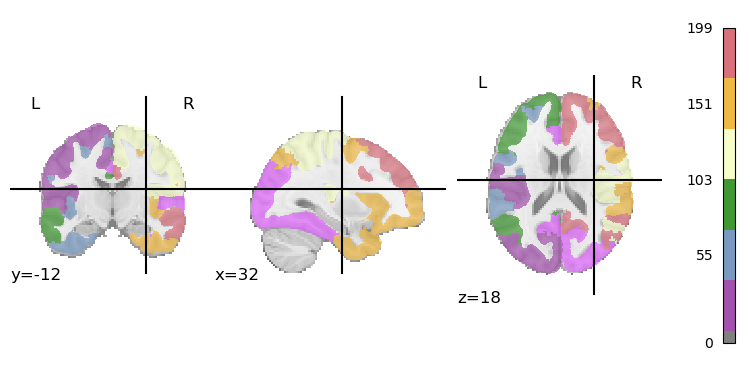

In [3]:
# Atlas Setup & Quick Visualization (Schaefer-2018, 200 parcels, Yeo-7)

start_time = datetime.now()

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=cfg.expect_regions, yeo_networks=7, resolution_mm=1)
atlas_filename = atlas.maps
labels = np.asarray(atlas.labels).astype('U')

# Yeo-7 inspired palette (7 colors)
my_colors = ['#A251AC', '#789AC1', '#409832', '#E165FE', '#F6FDC9', '#EFB944', '#D9717D']
cmap = ListedColormap(my_colors)

# Plot the atlas (display only, do not save)
disp = plotting.plot_roi(atlas_filename, cmap=cmap)
print(f'Atlas ROIs are located in nifti image at: {atlas_filename}')


## 3. Build Masker (Atlas-Based Time Series Extraction)

In [4]:
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds=True,
    memory="nilearn_cache",
    verbose=0,
    t_r=cfg.tr,
)

# connectome = ConnectivityMeasure(kind="correlation")
connectome = ConnectivityMeasure(kind="correlation", standardize="zscore_sample")

print(" Masker & ConnectivityMeasure Done ✅")
print(f"   Masker TR: {cfg.tr}s | Standardize: zscore_sample")
print(f"   FC kind: Pearson correlation")


 Masker & ConnectivityMeasure Done ✅
   Masker TR: 2.0s | Standardize: zscore_sample
   FC kind: Pearson correlation


In [5]:
def build_masker(atlas_filename: str, tr: float) -> NiftiLabelsMasker:
    # Prefer sample z-scoring if your nilearn supports it
    try:
        masker = NiftiLabelsMasker(
            labels_img=atlas_filename,
            standardize='zscore_sample',     # ok if available
            standardize_confounds=True,      # <-- must be bool
            memory='nilearn_cache',
            verbose=0,
            t_r=tr,
        )
    except TypeError:
        # Older nilearn: fallback to boolean standardize
        masker = NiftiLabelsMasker(
            labels_img=atlas_filename,
            standardize=True,
            standardize_confounds=True,      # <-- keep bool
            memory='nilearn_cache',
            verbose=0,
            t_r=tr,
        )
    return masker

if not hasattr(cfg, "atlas_filename"):
    cfg.atlas_filename = atlas.maps  # or the full path to your atlas .nii/.nii.gz
# masker = build_masker(cfg.atlas_filename, cfg.tr)

# Rebuild the masker before running test
masker = build_masker(atlas_filename, cfg.tr)

## 4. Utils: Raw NIfTI Files (Per Group) & Verify Pairing

In [6]:
def list_group_niis(group_dir: str, prefix: str) -> List[str]:
    patt1 = os.path.join(group_dir, f"{prefix}*.nii")
    patt2 = os.path.join(group_dir, f"{prefix}*.nii.gz")
    files = sorted(glob.glob(patt1) + glob.glob(patt2))
    return files

def pair_runs_consecutively(run_paths: List[str], runs_per_subject: int = 2) -> List[Tuple[str, ...]]:
    if len(run_paths) % runs_per_subject != 0:
        raise ValueError(
            f"Found {len(run_paths)} runs, not divisible by runs_per_subject={runs_per_subject}."
        )
    pairs = []
    for i in range(0, len(run_paths), runs_per_subject):
        pairs.append(tuple(run_paths[i : i + runs_per_subject]))
    return pairs

group_runs: Dict[str, List[str]] = {}
group_pairs: Dict[str, List[Tuple[str, ...]]] = {}

print("Scanning groups for raw NIfTI runs...")
for grp in cfg.groups:
    grp_dir = os.path.join(cfg.data_path, grp)
    if not os.path.isdir(grp_dir):
        raise FileNotFoundError(f"Group directory not found: {grp_dir}")

    runs = list_group_niis(grp_dir, cfg.fmri_prefix)
    group_runs[grp] = runs
    pairs = pair_runs_consecutively(runs, cfg.runs_per_subject)
    group_pairs[grp] = pairs

    # Summary
    print(f"   [{grp}] runs: {len(runs)} | subjects (by pairing): {len(pairs)}")
    if len(runs) > 0:
        print(f"     first 4 runs: {runs[:4]}")
    if len(pairs) > 0:
        print(f"     first pairing: {pairs[0]}")


Scanning groups for raw NIfTI runs...
   [pre_fes] runs: 14 | subjects (by pairing): 7
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes07a.r02.fanaticor+tlrc.nii.gz']
     first pairing: ('/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r01.fanaticor+tlrc.nii.gz', '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/fes_data/pre_fes/errts.scifes03a.r02.fanaticor+tlrc.nii.gz')
   [pre_nfes] runs: 10 | subjects (by pairing): 5
     first 4 runs: ['/Users/ismaila/Documents/C-Codes/SCI_FES_Grap

## 5. Helpers: Extract TS, Concatenate, Windowing, FC

In [7]:
def extract_run_timeseries(nii_path: str) -> np.ndarray:
    ts = masker.fit_transform(nii_path)  # (T, R)
    if ts.ndim != 2:
        raise ValueError(f"Timeseries not 2D for {nii_path}: {ts.shape}")
    if ts.shape[1] != cfg.expect_regions:
        raise ValueError(f"Expected {cfg.expect_regions} regions, got {ts.shape[1]} in {nii_path}")
    return ts

def concat_subject_runs(run_ts_list: List[np.ndarray]) -> np.ndarray:
    region_counts = {ts.shape[1] for ts in run_ts_list}
    if len(region_counts) != 1:
        raise ValueError(f"Region mismatch across runs: {region_counts}")
    return np.concatenate(run_ts_list, axis=0)

def sliding_window_indices(n_timepoints: int, window_trs: int, step_trs: int) -> List[Tuple[int, int]]:
    idx = []
    s = 0
    while s + window_trs <= n_timepoints:
        idx.append((s, s + window_trs))
        s += step_trs
    return idx

def timeseries_to_window_list(ts: np.ndarray, window_trs: int, step_trs: int) -> List[np.ndarray]:
    idx = sliding_window_indices(ts.shape[0], window_trs, step_trs)
    return [ts[s:e, :] for (s, e) in idx]


# Function 1: WITHOUT Fisher Z-Transform (original)
def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
    if len(windows) == 0:
        return np.zeros((0, 0, 0), dtype=np.float32)
    fc_list = connectome.fit_transform(windows)  # (n_windows, R, R)
    return np.asarray(fc_list, dtype=np.float32)
    
# # WITH Fisher Z-Transform
# def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
#     """
#     Compute functional connectivity per window with Fisher Z-Transform.
#     Handles diagonal (r=1) and near-perfect correlations to avoid infinities.
#     """
#     if len(windows) == 0:
#         return np.zeros((0, 0, 0), dtype=np.float32)
    
#     # Compute Pearson correlations
#     fc_list = connectome.fit_transform(windows)  # (n_windows, R, R) in [-1, 1]
    
#     # Clip to avoid infinity at exactly ±1
#     # Common threshold: 0.9999 or 1 - 1e-6
#     fc_clipped = np.clip(fc_list, -0.9999, 0.9999)
    
#     # Apply Fisher z-transform: r -> z
#     fc_z_list = np.arctanh(fc_clipped)
    
#     # Trying to Set diagonal to 0 (since self-correlation is meaningless in z-space) 
#     for i in range(fc_z_list.shape[0]):
#         np.fill_diagonal(fc_z_list[i], 0)
    
#     return np.asarray(fc_z_list, dtype=np.float32)


# def compute_fc_per_window(windows: List[np.ndarray]) -> np.ndarray:
#     """
#     Compute functional connectivity per window with Fisher Z-Transform.
#     Filters out windows with zero-variance regions.
#     """
#     if len(windows) == 0:
#         return np.zeros((0, 0, 0), dtype=np.float32)
    
#     # Filter windows to remove those with zero-variance regions
#     valid_windows = []
#     for win in windows:
#         # Check if any region has zero variance
#         if np.all(np.std(win, axis=0) > 1e-10):
#             valid_windows.append(win)
#         else:
#             print(f"[warn] Skipping window with zero-variance region(s)")
    
#     if len(valid_windows) == 0:
#         print("[error] All windows have zero-variance regions!")
#         return np.zeros((0, 0, 0), dtype=np.float32)
    
#     # Compute correlations
#     fc_list = connectome.fit_transform(valid_windows)
    
#     # Clip to avoid infinity at exactly ±1
#     fc_safe = np.clip(fc_list, -0.99999, 0.99999)
    
#     # Apply Fisher z-transform
#     fc_z_list = np.arctanh(fc_safe)
    
#     return np.asarray(fc_z_list, dtype=np.float32)
    

## 6. Parameter Translation & Sanity Check

In [8]:
# Parameter Translation & Sanity check

window_trs = int(round(cfg.window_length_sec / cfg.tr))
step_trs = int(cfg.step_size_tr)

if window_trs < 2:
    raise ValueError("window_trs must be >= 2.")
if step_trs < 1:
    raise ValueError("step_trs must be >= 1.")

expected_trs_per_run = int(round(7 * 60 / cfg.tr))  # ~7 minutes per run
print(f"   window_trs: {window_trs} (from {cfg.window_length_sec}s @ TR={cfg.tr}s)")
print(f"   step_trs:   {step_trs}")
print(f"   expected TRs per run (≈7min): {expected_trs_per_run}")

   window_trs: 15 (from 30.0s @ TR=2.0s)
   step_trs:   8
   expected TRs per run (≈7min): 210


## 7. Run on One Subject (Group1 or cFES_Pre)

In [9]:
# One Subject Test (First Group)

test_grp = cfg.groups[0]
if len(group_pairs[test_grp]) == 0:
    raise RuntimeError(f"No subject pairings in group: {test_grp}")

test_pair = group_pairs[test_grp][0]
run_ts_list = []

print(f"run on group '{test_grp}', subject pair:")
for rp in test_pair:
    print(f"   - Extracting TS: {os.path.basename(rp)}")
    ts = extract_run_timeseries(rp)
    run_ts_list.append(ts)
    # Warn if TR count deviates notably from ~210 for 7min@2s
    if abs(ts.shape[0] - expected_trs_per_run) > 10:
        print(f"     [warn] timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
    print(f"     TS shape: {ts.shape}")

ts_concat = concat_subject_runs(run_ts_list)
print(f"   Concatenated TS shape: {ts_concat.shape} (expect ~420 x {cfg.expect_regions})")

windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
print(f"   Windows created: {len(windows)} (expect ~{ts_concat.shape[0] - window_trs + 1} for step=1)")

fc_w = compute_fc_per_window(windows)
print(f"   FC per-window shape: {fc_w.shape}  (windows x {cfg.expect_regions} x {cfg.expect_regions})")

assert fc_w.ndim == 3 and fc_w.shape[1] == cfg.expect_regions and fc_w.shape[2] == cfg.expect_regions
print("Test done ✅")

run on group 'pre_fes', subject pair:
   - Extracting TS: errts.scifes03a.r01.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   - Extracting TS: errts.scifes03a.r02.fanaticor+tlrc.nii.gz
     TS shape: (205, 200)
   Concatenated TS shape: (410, 200) (expect ~420 x 200)
   Windows created: 50 (expect ~396 for step=1)
   FC per-window shape: (50, 200, 200)  (windows x 200 x 200)
Test done ✅


## 8. Pipeline: All Groups-to-FC Tensors

In [10]:
# Full Processing: All Groups → FC Tensors (with Checks)

group_fc_results: Dict[str, np.ndarray] = {}
print("Processing all groups...")

for grp in cfg.groups:
    pairs = group_pairs[grp]
    if len(pairs) == 0:
        print(f"   [{grp}] No subjects found; skipping.")
        continue

    subj_fc_list = []
    n_windows_ref = None

    print(f"   [{grp}] subjects={len(pairs)}")
    for si, pair in enumerate(pairs, start=1):
        run_ts_list = []
        for rp in pair:
            ts = extract_run_timeseries(rp)
            # Quick TR sanity check
            if abs(ts.shape[0] - expected_trs_per_run) > 10 and cfg.verbose:
                print(f"     [warn] {os.path.basename(rp)}: timepoints={ts.shape[0]} (expected ~{expected_trs_per_run})")
            run_ts_list.append(ts)

        ts_concat = concat_subject_runs(run_ts_list)
        windows = timeseries_to_window_list(ts_concat, window_trs, step_trs)
        if len(windows) == 0:
            raise ValueError(f"No windows for subject {si} in group {grp} (T={ts_concat.shape[0]}, window_trs={window_trs}).")

        fc_w = compute_fc_per_window(windows)

        if n_windows_ref is None:
            n_windows_ref = fc_w.shape[0]
        elif fc_w.shape[0] != n_windows_ref:
            raise ValueError(f"[{grp}] Inconsistent window counts across subjects: first had {n_windows_ref}, now {fc_w.shape[0]}")

        subj_fc_list.append(fc_w)
        if cfg.verbose:
            print(f"     Subject {si}: TS {ts_concat.shape} | windows={fc_w.shape[0]} | FC shape={fc_w.shape}")

    grp_tensor = np.stack(subj_fc_list, axis=0).astype(np.float32)  # (subjects, windows, R, R)
    group_fc_results[grp] = grp_tensor
    print(f"   [{grp}] FC tensor: {grp_tensor.shape} (subjects x windows x {cfg.expect_regions} x {cfg.expect_regions})")

print("All groups processed Done✅")


Processing all groups...
   [pre_fes] subjects=7
     Subject 1: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 2: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 3: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 4: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 5: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 6: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 7: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
   [pre_fes] FC tensor: (7, 50, 200, 200) (subjects x windows x 200 x 200)
   [pre_nfes] subjects=5
     Subject 1: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 2: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 3: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 4: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
     Subject 5: TS (410, 200) | windows=50 | FC shape=(50, 200, 200)
   [pre_nfes] FC tensor

## 9. Inspect Results (Shapes, Counts, Example Subject/Window)

In [11]:
def describe_group(group_key: str, result_map: Dict[str, np.ndarray]):
    arr = result_map[group_key]
    n_subj, n_win, r1, r2 = arr.shape
    print(f"Group={group_key}: subjects={n_subj}, windows={n_win}, regions={r1}x{r2}")
    return n_subj, n_win, r1, r2

# Example:
if 'group_fc_results' in globals():
    for g in cfg.groups:
        describe_group(g, group_fc_results)
    # Peek at one subject/window
    g0 = cfg.groups[0]
    FC_example = group_fc_results[g0][0, 0]  # subject 0, window 0 -> (200, 200)
    print("Example FC matrix stats:", np.min(FC_example), np.max(FC_example), np.mean(FC_example))


Group=pre_fes: subjects=7, windows=50, regions=200x200
Group=pre_nfes: subjects=5, windows=50, regions=200x200
Group=post_fes: subjects=7, windows=50, regions=200x200
Group=post_nfes: subjects=5, windows=50, regions=200x200
Example FC matrix stats: -0.8182032 1.0 0.6151184


## 10. Visualization of One FC Matrix

        pre_fes: (7, 50, 200, 200)
       pre_nfes: (5, 50, 200, 200)
       post_fes: (7, 50, 200, 200)
      post_nfes: (5, 50, 200, 200)

   Example from [pre_fes] subj 1, win 1 -> FC stats: min=-0.8182, max=1.0000, mean=0.6151


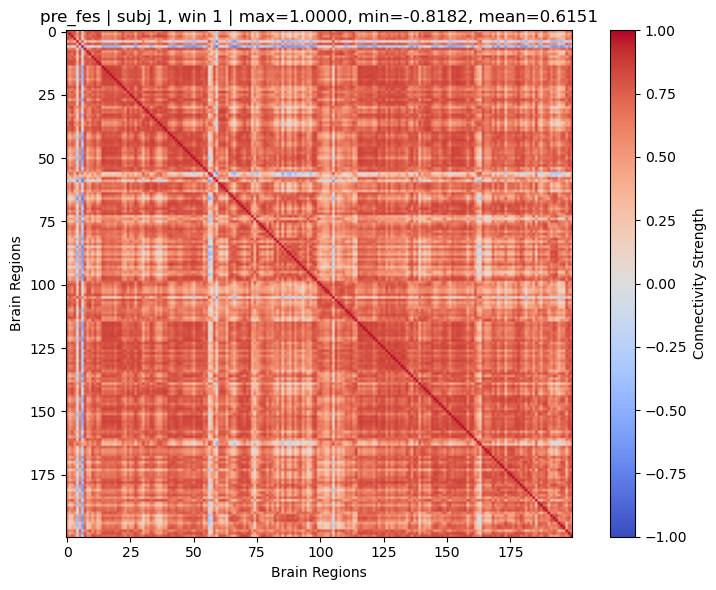

In [14]:
# Summary of FC tensors (subjects x windows x regions x regions)
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

# ----- Choose which group / subject / window to visualize -----
g_idx = 0   # index into cfg.groups (0-based). Change this to pick a different group.
subj  = 1   # subject number (min is 1). Change this to pick a different subject.
win   = 1   # window number  (min is 1). Change this to pick a different window.
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape

            # Validate subj/win (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win <= n_win):
                print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj - 1
                win_idx  = win  - 1

                FC_example = arr[subj_idx, win_idx]  # (R, R)
                print(f"\n   Example from [{g0}] subj {subj}, win {win} -> FC stats: "
                      f"min={np.min(FC_example):.4f}, max={np.max(FC_example):.4f}, mean={np.mean(FC_example):.4f}")

                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(f'{g0} | subj {subj}, win {win} | max={np.max(FC_example):.4f}, min={np.min(FC_example):.4f}, mean={np.mean(FC_example):.4f}')
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
                plt.tight_layout()
                plt.show()
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")


        pre_fes: (7, 50, 200, 200)
       pre_nfes: (5, 50, 200, 200)
       post_fes: (7, 50, 200, 200)
      post_nfes: (5, 50, 200, 200)

   Example 1 from [pre_fes] subj 1, win 2 -> FC stats: min=-0.7243, max=1.0000, mean=0.4760

   Example 2 from [post_fes] subj 1, win 2 -> FC stats: min=-0.3973, max=1.0000, mean=0.0218


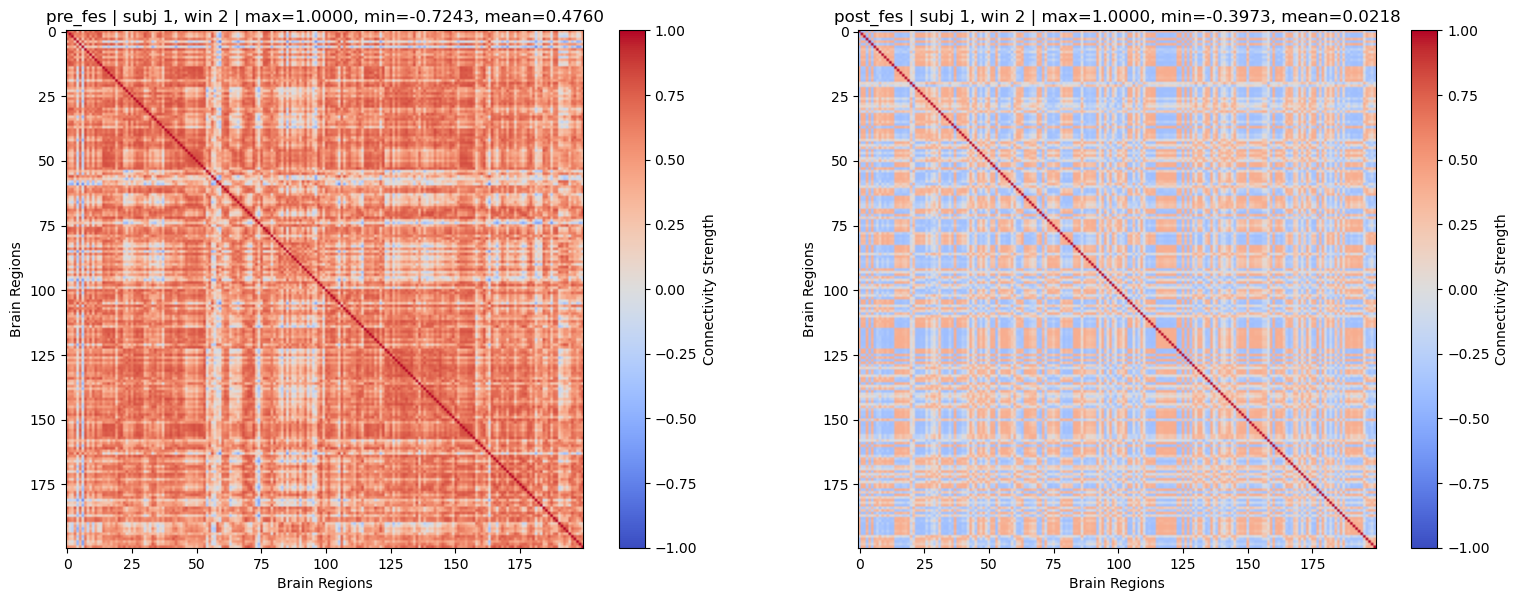

In [15]:
# Summary of FC tensors (subjects x windows x regions x regions)
for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

#   # e.g choose one from 0..3..6 (PreFES) 7..9..11 (PreNFES) 1st, 4th, 7th; 1st, 3rd, 5th
#   # e.g choose one from 12..15..18 (PostFES) 19..21..23 (PostNFES)

# ----- Choose which group / subject / window to visualize -----
# First visualization
g_idx_1 = 0   # index into cfg.groups (0-based). Change this to pick a different group.
subj_1  = 1   # subject number (min is 1). Change this to pick a different subject.
win_1   = 2   # window number  (min is 1). Change this to pick a different window.

# Second visualization
g_idx_2 = 2   # index into cfg.groups (0-based). Change this to pick a different group.
subj_2  = 1   # subject number (min is 1). Change this to pick a different subject.
win_2   = 2   # window number  (min is 1). Change this to pick a different window.
# --------------------------------------------------------------

if len(group_fc_results) > 0:
    # Create figure with 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Process first visualization
    if not (0 <= g_idx_1 < len(cfg.groups)):
        print(f"   Invalid g_idx_1={g_idx_1}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx_1]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape
            # Validate subj/win (1-based)
            if not (1 <= subj_1 <= n_subj):
                print(f"   Invalid subj_1={subj_1}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win_1 <= n_win):
                print(f"   Invalid win_1={win_1}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj_1 - 1
                win_idx  = win_1  - 1
                FC_example = arr[subj_idx, win_idx]  # (R, R)
                print(f"\n   Example 1 from [{g0}] subj {subj_1}, win {win_1} -> FC stats: "
                      f"min={np.min(FC_example):.4f}, max={np.max(FC_example):.4f}, mean={np.mean(FC_example):.4f}")
                
                ax = axes[0]
                im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(f'{g0} | subj {subj_1}, win {win_1} | max={np.max(FC_example):.4f}, min={np.min(FC_example):.4f}, mean={np.mean(FC_example):.4f}')
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
        else:
            print("   No FC results available to visualize for the first selected group.")
    
    # Process second visualization
    if not (0 <= g_idx_2 < len(cfg.groups)):
        print(f"   Invalid g_idx_2={g_idx_2}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx_2]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape
            # Validate subj/win (1-based)
            if not (1 <= subj_2 <= n_subj):
                print(f"   Invalid subj_2={subj_2}. Valid range for [{g0}] is 1..{n_subj}.")
            elif not (1 <= win_2 <= n_win):
                print(f"   Invalid win_2={win_2}. Valid range for [{g0}] is 1..{n_win}.")
            else:
                subj_idx = subj_2 - 1
                win_idx  = win_2  - 1
                FC_example = arr[subj_idx, win_idx]  # (R, R)
                print(f"\n   Example 2 from [{g0}] subj {subj_2}, win {win_2} -> FC stats: "
                      f"min={np.min(FC_example):.4f}, max={np.max(FC_example):.4f}, mean={np.mean(FC_example):.4f}")
                
                ax = axes[1]
                im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                ax.set_title(f'{g0} | subj {subj_2}, win {win_2} | max={np.max(FC_example):.4f}, min={np.min(FC_example):.4f}, mean={np.mean(FC_example):.4f}')
                ax.set_xlabel('Brain Regions')
                ax.set_ylabel('Brain Regions')
                fig.colorbar(im, ax=ax, label='Connectivity Strength')
        else:
            print("   No FC results available to visualize for the second selected group.")
    
    plt.tight_layout()
    plt.show()
else:
    print("   group_fc_results is empty.")

In [16]:
# for g, arr in group_fc_results.items():
#     print(f"   {g:>12}: {arr.shape}")

# g_idx = 0   
# subj  = 1   
# win   = 5   
# # Grid layout
# n_cols = 3  
# n_rows = 5 # window-based FCs
# # --------------------------------------------------------------

# if len(group_fc_results) > 0:
#     # Validate group index
#     if not (0 <= g_idx < len(cfg.groups)):
#         print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
#     else:
#         g0 = cfg.groups[g_idx]
#         if g0 in group_fc_results and group_fc_results[g0].size > 0:
#             arr = group_fc_results[g0]
#             n_subj, n_win, r1, r2 = arr.shape

#             # Validate subj/win (1-based)
#             if not (1 <= subj <= n_subj):
#                 print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
#             elif not (1 <= win <= n_win):
#                 print(f"   Invalid win={win}. Valid range for [{g0}] is 1..{n_win}.")
#             else:
#                 subj_idx = subj - 1
#                 start_w  = win - 1
#                 max_panels = n_cols * n_rows
#                 end_w   = min(start_w + max_panels, n_win)  # exclusive
#                 k = end_w - start_w
#                 if k <= 0:
#                     print(f"   No windows available from win={win} in [{g0}].")
#                 else:
#                     # Prepare figure grid
#                     fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.0, n_rows*3.2))
#                     axes = axes.ravel()

#                     # Track global stats over displayed windows
#                     mins, maxs, means = [], [], []

#                     im = None
#                     for i in range(n_cols * n_rows):
#                         ax = axes[i]
#                         if i < k:
#                             w_idx = start_w + i
#                             FC_example = arr[subj_idx, w_idx]  # (R, R)
#                             mins.append(np.min(FC_example))
#                             maxs.append(np.max(FC_example))
#                             means.append(np.mean(FC_example))

#                             im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
#                             ax.set_title(f'win {w_idx+1}', fontsize=10)
#                             ax.set_xlabel('Regions', fontsize=9)
#                             ax.set_ylabel('Regions', fontsize=9)
#                         else:
#                             ax.axis('off')

#                     # One shared colorbar for all subplots
#                     if im is not None:
#                         #cbar = fig.colorbar(im, ax=axes.tolist(), location='top', orientation='horizontal', fraction=0.02, pad=0.01, label='Connectivity Strength')
                        
#                         cax = fig.add_axes([0.2, 0.94, 0.6, 0.01])  # [left, bottom, width, height] in figure coords
#                         cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
#                         cbar.set_label('Connectivity Strength')

#                         # leave space for the top bar and tighten subplot spacing if needed
#                         fig.subplots_adjust(top=0.90, wspace=0.05, hspace=0.35)

                        
#                     # Suptitle with context and summary stats
#                     if k > 0:
#                         fig.suptitle(
#                             f'{g0} | subj {subj} | windows {start_w+1}–{start_w+k} '
#                             f'| min={np.min(mins):.3f}, max={np.max(maxs):.3f}, mean≈{np.mean(means):.3f}',
#                             fontsize=12, y=0.995
#                         )
#                     #plt.tight_layout(rect=[0, 0, 1, 0.98])
#                     plt.show()
#         else:
#             print("   No FC results available to visualize for the selected group.")
# else:
#     print("   group_fc_results is empty.")

        pre_fes: (7, 50, 200, 200)
       pre_nfes: (5, 50, 200, 200)
       post_fes: (7, 50, 200, 200)
      post_nfes: (5, 50, 200, 200)


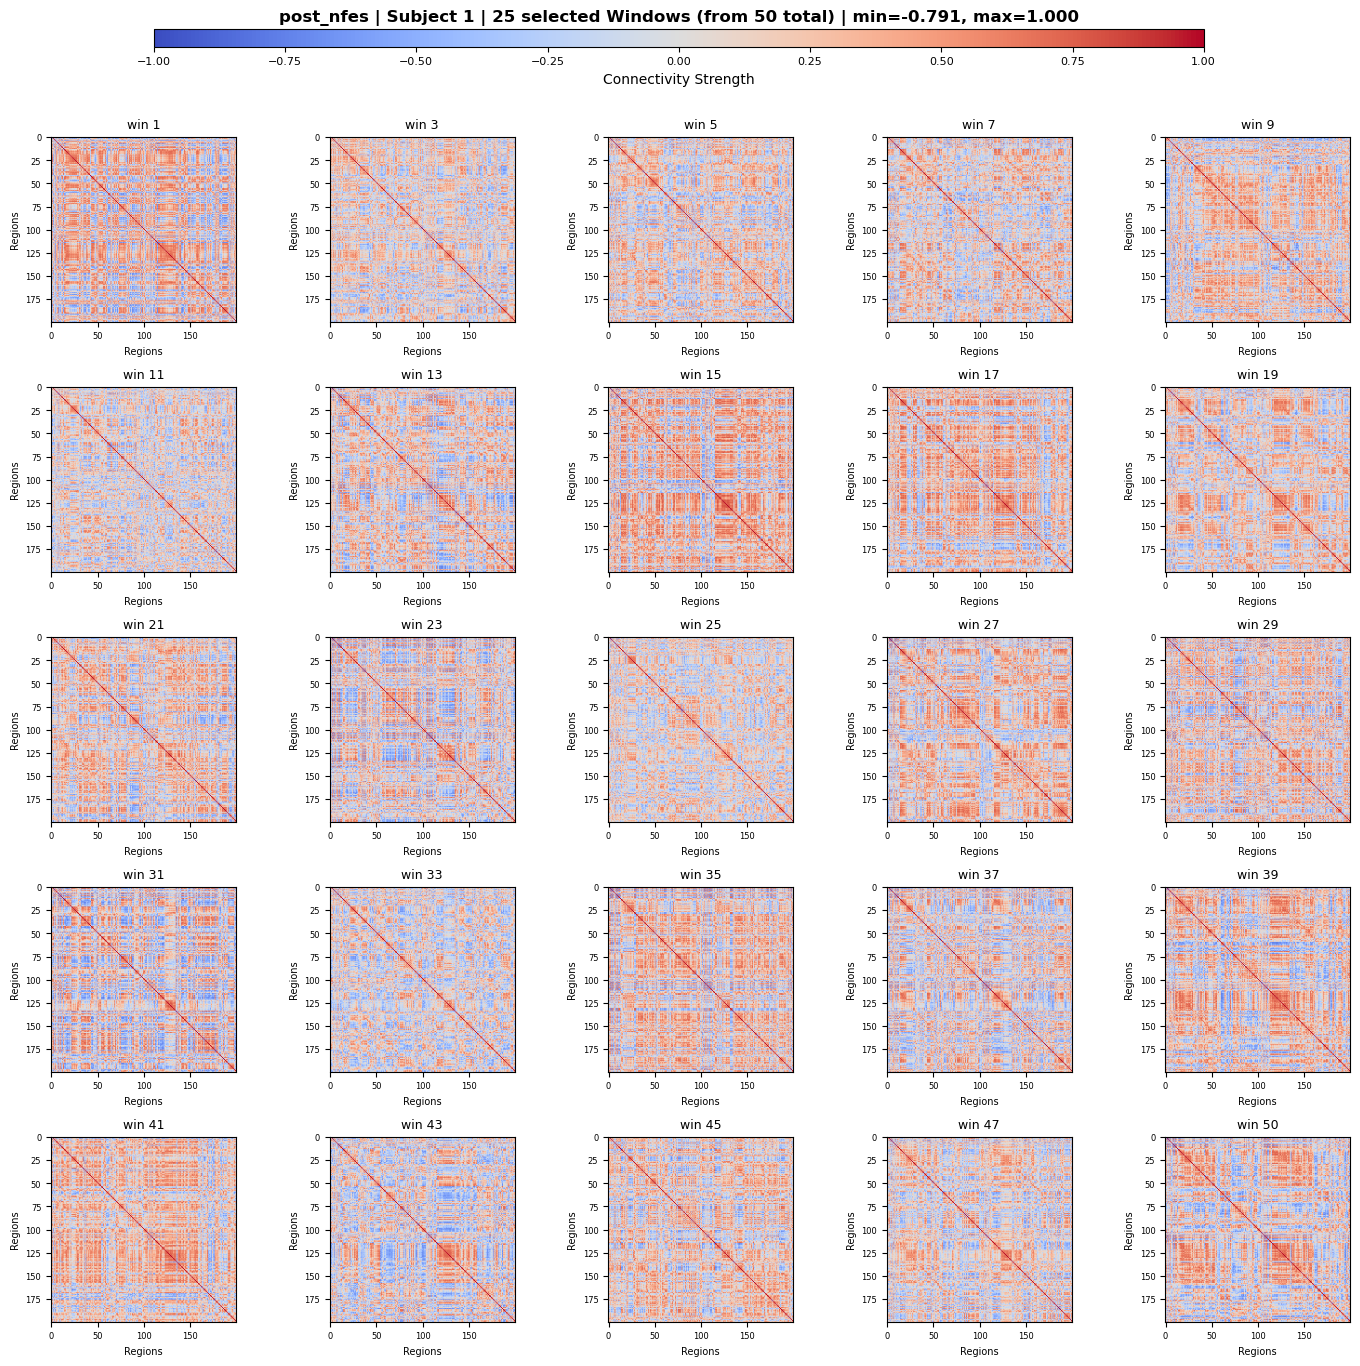


✓ Displayed windows: [ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 50]


In [17]:
#   # e.g choose one from 0..3..6 (PreFES) 7..9..11 (PreNFES) 1st, 4th, 7th; 1st, 3rd, 5th
#   # e.g choose one from 12..15..18 (PostFES) 19..21..23 (PostNFES)


for g, arr in group_fc_results.items():
    print(f"   {g:>12}: {arr.shape}")

g_idx = 3   
subj  = 1   
win   = 1   

# Grid layout
n_cols = 5  
n_rows = 5  # 5x5 = 25 window-based FCs

# --------------------------------------------------------------
if len(group_fc_results) > 0:
    # Validate group index
    if not (0 <= g_idx < len(cfg.groups)):
        print(f"   Invalid g_idx={g_idx}. Valid range is 0..{len(cfg.groups)-1}.")
    else:
        g0 = cfg.groups[g_idx]
        if g0 in group_fc_results and group_fc_results[g0].size > 0:
            arr = group_fc_results[g0]
            n_subj, n_win, r1, r2 = arr.shape
            # Validate subj (1-based)
            if not (1 <= subj <= n_subj):
                print(f"   Invalid subj={subj}. Valid range for [{g0}] is 1..{n_subj}.")
            else:
                subj_idx = subj - 1
                
                # Select 25 evenly-spaced windows from the 50 available
                max_panels = n_cols * n_rows  # 25
                if n_win < max_panels:
                    # If fewer than 25 windows, use all available
                    selected_windows = np.arange(n_win)
                else:
                    # Evenly space 25 windows across 50
                    selected_windows = np.linspace(0, n_win-1, max_panels, dtype=int)
                
                k = len(selected_windows)
                
                if k <= 0:
                    print(f"   No windows available in [{g0}].")
                else:
                    # Prepare figure grid
                    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.0))
                    axes = axes.ravel()
                    
                    # Track global stats over displayed windows
                    mins, maxs, means = [], [], []
                    im = None
                    
                    for i in range(n_cols * n_rows):
                        ax = axes[i]
                        if i < k:
                            w_idx = selected_windows[i]
                            FC_example = arr[subj_idx, w_idx]  # (R, R)
                            mins.append(np.min(FC_example))
                            maxs.append(np.max(FC_example))
                            means.append(np.mean(FC_example))
                            
                            im = ax.imshow(FC_example, cmap='coolwarm', vmin=-1, vmax=1)
                            ax.set_title(f'win {w_idx+1}', fontsize=9)
                            ax.set_xlabel('Regions', fontsize=7)
                            ax.set_ylabel('Regions', fontsize=7)
                            ax.tick_params(labelsize=6)
                        else:
                            ax.axis('off')
                    
                    # One shared colorbar for all subplots
                    if im is not None:
                        cax = fig.add_axes([0.2, 0.96, 0.6, 0.012])  # [left, bottom, width, height]
                        cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
                        cbar.set_label('Connectivity Strength', fontsize=10)
                        cbar.ax.tick_params(labelsize=8)
                        fig.subplots_adjust(top=0.90, wspace=0.15, hspace=0.35)
                    
                    # Suptitle with context and summary stats
                    if k > 0:
                        fig.suptitle(
                            f'{g0} | Subject {subj} | 25 selected Windows (from {n_win} total) '
                            f'| min={np.min(mins):.3f}, max={np.max(maxs):.3f}',
                            fontsize=12, y=0.985, fontweight='bold'
                        )
                    
                    plt.show()
                    print(f"\n✓ Displayed windows: {selected_windows + 1}")  # Show 1-based indices
        else:
            print("   No FC results available to visualize for the selected group.")
else:
    print("   group_fc_results is empty.")

## 11. Save outputs for Multi-layer community detection algorithm

In [18]:
# # Save correlations to .mat with ALL WINDOWS (concatenated) per group
# # For each group variable corr_<group>: shape = (subjects*windows, regions, regions)

# corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

# if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
#     print("No FC results available to save")
# else:
#     os.makedirs(corr_path, exist_ok=True)

#     # --- Pass 1: build per-group payloads (and print shapes) ---
#     per_group_payload = {}
#     for g, arr in group_fc_results.items():  # arr: (subjects, windows, R, R)
#         # Sanitize group name for MATLAB variable rules
#         safe_g = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in g)
#         if not safe_g or not safe_g[0].isalpha():
#             safe_g = f"grp_{safe_g}"

#         S, W, R1, R2 = arr.shape
#         assert R1 == R2 == 200, f"Unexpected region size for {g}: {(R1, R2)}"

#         # Flatten subjects x windows -> (S*W, R, R)
#         windows_all = arr.reshape(S * W, R1, R2).astype(np.float32)
#         idx_rows = np.repeat(np.arange(S), W)        # subject indices
#         idx_cols = np.tile(np.arange(W), S)          # window indices
#         idx_map   = np.column_stack([idx_rows, idx_cols]).astype(np.int32)

#         # Store a per-group dict we can reuse for any save option
#         per_group_payload[g] = {
#             f'corr_{safe_g}': windows_all,
#             f'idx_map_{safe_g}': idx_map,
#             '__meta__': {
#                 'group': np.array([g], dtype=object),
#                 'regions': np.array([200], dtype=np.int32),
#                 'note': np.array(["corr_* has shape (subjects*windows, regions, regions)"], dtype=object),
#                 'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
#                 'shape_original': np.array([S, W, R1, R2], dtype=np.int32),
#             }
#         }

#         print(f"Prepared corr_{safe_g}: {windows_all.shape}  (subjects*windows, regions, regions) "
#               f"from original {arr.shape}")

#     # --- Option A: 4 separate files (one per group) ---
#     for g, payload in per_group_payload.items():
#         safe_g = list(payload.keys())[0].replace('corr_', '')  # recover sanitized group token
#         out_file = os.path.join(corr_path, f"corr_{safe_g}_{cfg.step_size_tr}tr_windows.mat")
#         savemat(out_file, payload)
#         print(f"Saved per-group file -> {out_file}") 

#     # --- Option B: 2 combined files (FES vs Passive/NFES) ---
#     # Detect groups by name keys you used: 'pre_fes','post_fes','pre_nfes','post_nfes'
#     fes_groups     = [k for k in per_group_payload.keys() if 'fes' in k and 'nfes' not in k]
#     passive_groups = [k for k in per_group_payload.keys() if 'nfes' in k]

#     # Build combined dicts
#     fes_payload = {}
#     for g in fes_groups:
#         for k, v in per_group_payload[g].items():
#             fes_payload[k] = v
#     fes_payload['__meta__'] = {
#         'groups': np.array(fes_groups, dtype=object),
#         'regions': np.array([200], dtype=np.int32),
#         'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
#         'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
#     }
#     out_fes = os.path.join(corr_path, f"corr_FES_{cfg.step_size_tr}tr_windows.mat")
#     savemat(out_fes, fes_payload)
#     print(f"Saved combined FES file -> {out_fes}")

#     passive_payload = {}
#     for g in passive_groups:
#         for k, v in per_group_payload[g].items():
#             passive_payload[k] = v
#     passive_payload['__meta__'] = {
#         'groups': np.array(passive_groups, dtype=object),
#         'regions': np.array([200], dtype=np.int32),
#         'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
#         'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
#     }
#     out_passive = os.path.join(corr_path, f"corr_Passive_{cfg.step_size_tr}tr_windows.mat")
#     savemat(out_passive, passive_payload)
#     print(f"Saved combined Passive/NFES file -> {out_passive}")

#     # --- Option C: single file with all four groups (your original behavior) ---
#     all_payload = {}
#     for g, payload in per_group_payload.items():
#         for k, v in payload.items():
#             if k != '__meta__':
#                 all_payload[k] = v
#     all_payload['__meta__'] = {
#         'groups': np.array(list(per_group_payload.keys()), dtype=object),
#         'regions': np.array([200], dtype=np.int32),
#         'note': np.array(["Each corr_* = (subjects*windows, regions, regions)"], dtype=object),
#         'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
#     }
#     out_all = os.path.join(corr_path, f"corr_all_groups_{cfg.step_size_tr}tr_windows.mat")
#     savemat(out_all, all_payload)
#     print(f"Saved single file with all groups -> {out_all}")

### FC verification step - (subject selection)

In [21]:
# Save correlations to .mat with ALL WINDOWS (concatenated) per group
# For each group variable corr_<group>: shape = (subjects*windows, regions, regions)

corr_path = '/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/'

if 'group_fc_results' not in globals() or len(group_fc_results) == 0:
    print("No FC results available to save")
else:
    os.makedirs(corr_path, exist_ok=True)

    # --- Pass 1: build per-group payloads (and print shapes) ---
    per_group_payload = {}
    for g, arr in group_fc_results.items():  # arr: (subjects, windows, R, R)
        # Select only first subject
        # arr = arr[0:1, :, :, :]  # Shape becomes (1, windows, R, R)
        
        # Sanitize group name for MATLAB variable rules
        safe_g = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in g)
        if not safe_g or not safe_g[0].isalpha():
            safe_g = f"grp_{safe_g}"

        S, W, R1, R2 = arr.shape
        assert R1 == R2 == 200, f"Unexpected region size for {g}: {(R1, R2)}"

        # Flatten subjects x windows -> (S*W, R, R)
        windows_all = arr.reshape(S * W, R1, R2).astype(np.float32)
        idx_rows = np.repeat(np.arange(S), W)        # subject indices
        idx_cols = np.tile(np.arange(W), S)          # window indices
        idx_map   = np.column_stack([idx_rows, idx_cols]).astype(np.int32)

        # Store a per-group dict we can reuse for any save option
        per_group_payload[g] = {
            f'corr_{safe_g}': windows_all,
            f'idx_map_{safe_g}': idx_map,
            '__meta__': {
                'group': np.array([g], dtype=object),
                'regions': np.array([200], dtype=np.int32),
                'note': np.array(["corr_* has shape (subjects*windows, regions, regions)"], dtype=object),
                'index_info': np.array(["idx_map_* rows: [subject_index_0based, window_index_0based]"], dtype=object),
                'shape_original': np.array([S, W, R1, R2], dtype=np.int32),
            }
        }

        print(f"Prepared corr_{safe_g}: {windows_all.shape}  (subjects*windows, regions, regions) "
              f"from original {arr.shape}")
        
        # Save correlation matrices as .xlsx file
        xlsx_file = os.path.join(corr_path, f"corr_{safe_g}_{cfg.step_size_tr}tr_windows.xlsx")
        with pd.ExcelWriter(xlsx_file, engine='openpyxl') as writer:
            for w_idx in range(windows_all.shape[0]):
                sheet_name = f'Window_{w_idx+1}'
                df = pd.DataFrame(windows_all[w_idx, :, :])
                df.to_excel(writer, sheet_name=sheet_name, index=True)
        print(f"Saved correlation matrices to Excel -> {xlsx_file}")

    # --- Option A: 4 separate files (one per group) ---
    for g, payload in per_group_payload.items():
        safe_g = list(payload.keys())[0].replace('corr_', '')  # recover sanitized group token
        out_file = os.path.join(corr_path, f"corr_{safe_g}_{cfg.step_size_tr}tr_windows.mat")
        savemat(out_file, payload)
        print(f"Saved per-group file -> {out_file}")

Prepared corr_pre_fes: (350, 200, 200)  (subjects*windows, regions, regions) from original (7, 50, 200, 200)
Saved correlation matrices to Excel -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_fes_8tr_windows.xlsx
Prepared corr_pre_nfes: (250, 200, 200)  (subjects*windows, regions, regions) from original (5, 50, 200, 200)
Saved correlation matrices to Excel -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_pre_nfes_8tr_windows.xlsx
Prepared corr_post_fes: (350, 200, 200)  (subjects*windows, regions, regions) from original (7, 50, 200, 200)
Saved correlation matrices to Excel -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_post_fes_8tr_windows.xlsx
Prepared corr_post_nfes: (250, 200, 200)  (subjects*windows, regions, regions) from original (5, 50, 200, 200)
Saved correlation matrices to Excel -> /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/fc/corr_post_nfes_8tr_windows.x



### 🔁 Python ↔ MATLAB ↔ Python Workflow




## 12. Load MATLAB v7.3 (HDF5) file after Multi-layer community label assign.

In [19]:
# from pathlib import Path
# import numpy as np
# import h5py

# # ----------------------------
# # Paths (edit as needed) 
# # ----------------------------
# # Base directory where MATLAB saved the per-group outputs
# BASE_DIR = Path("/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var")
# # BASE_DIR = Path("/Users/ismaila/Downloads/mlcd_new")
# # Tags & filenames must match your MATLAB saves
# TAGS = ["prefes", "prenfes", "postfes", "postnfes"]
# # TAGS = ["pre_fes", "pre_nfes", "post_fes", "post_nfes"]
# FNAME_TEMPLATE = "mlcd_{tag}_8tr_wins.mat"  # filenames
# # FNAME_TEMPLATE = "mlcd_{tag}_8tr_g1o1.mat"  # filenames 
# # FNAME_TEMPLATE = "mlcd_{tag}_8tr_wins_g1o1_10.mat"  # filenames 

# # Map each tag to the correct variable name found in the MAT files
# NALLG_VAR_FOR_TAG = {
#     "prefes":   "N_all_g_prefes",
#     "prenfes":  "N_all_g_prenfes",
#     "postfes":  "N_all_g_postfes",
#     "postnfes": "N_all_g_postnfes",
# }

# # Expected number of nodes (rows). Adjust if your N != 200.
# N_EXPECTED = 200

# def read_var(f: h5py.File, varname: str):
#     """Read a variable from a v7.3 MAT file using h5py, with a friendly error if missing."""
#     if varname not in f:
#         # Show what's available to help debugging
#         keys = list(f.keys())
#         raise KeyError(f"Variable '{varname}' not found. Available keys: {keys}")
#     arr = f[varname][()]
#     return np.squeeze(np.asarray(arr))

# def fix_orientation(mat: np.ndarray, n_expected: int) -> np.ndarray:
#     """
#     Ensure matrix is shaped (N, T). If we see (T, N), transpose.
#     If already (N, T), keep as-is.
#     """
#     if mat.ndim != 2:
#         raise ValueError(f"Expected 2D matrix, got shape {mat.shape}")
#     r, c = mat.shape
#     if r == n_expected:
#         return mat  # already (N, T)
#     if c == n_expected:
#         return mat.T  # was (T, N), make (N, T)
#     # As a fallback, if one dim equals N, orient accordingly:
#     if n_expected in (r, c):
#         return mat if r == n_expected else mat.T
#     # Otherwise, warn explicitly
#     raise ValueError(f"Neither dimension matches N={n_expected}. Got {mat.shape}")

# # ----------------------------
# # Load N_all_g from each group file and concatenate
# # ----------------------------
# group_tags = ['prefes', 'prenfes', 'postfes', 'postnfes']
# # group_tags = ["pre_fes", "pre_nfes", "post_fes", "post_nfes"]
# N_all_g_list = []

# for tag in group_tags:
#     mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
#     if not mat_path.exists():
#         raise FileNotFoundError(f"File not found: {mat_path}")
    
#     with h5py.File(mat_path, 'r') as f:
#         # Read N_all_g_<tag> depending on tag
#         varname = NALLG_VAR_FOR_TAG[tag]
#         N_all_g_tag = read_var(f, varname)
        
#         # Fix orientation to (N, T)
#         N_all_g_tag = fix_orientation(N_all_g_tag, N_EXPECTED)
#         N_all_g_list.append(N_all_g_tag)
        
#         print(f"Loaded {varname}: {N_all_g_tag.shape}")

# # Concatenate all groups along columns (time/windows dimension)
# N_all_g = np.concatenate(N_all_g_list, axis=1)
# print(f"\nCombined N_all_g shape: {N_all_g.shape}")

# # ----------------------------
# # Split into subjects then 4 groups
# # ----------------------------
# N, total_cols = N_all_g.shape
# assert N == 200, f"Expected 200 regions (rows), got {N}"

# n_subjects = 24  # per your draft spec
# assert total_cols % n_subjects == 0, f"{total_cols} not divisible by {n_subjects}"
# wins_per_subj = total_cols // n_subjects
# print(f"Inferred wins_per_subj: {wins_per_subj}")

# # Slice into [subject_0, subject_1, ..., subject_23], each (200, wins_per_subj)
# subjects = [N_all_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]

# print(f"\n{n_subjects} subjects extracted:")
# for i, subj in enumerate(subjects, 1):
#     print(f"  subj {i:02d}: {subj.shape}")

# # By default, assume 6 subjects per group in the order you ran
# subjects_per_group = n_subjects // 4
# assert subjects_per_group * 4 == n_subjects, "Subjects not divisible into 4 equal groups."

# group_slices = {
#     'prefes':   (0, subjects_per_group),                          # subjects 0..5
#     'prenfes':  (subjects_per_group, 2*subjects_per_group),       # subjects 6..11
#     'postfes':  (2*subjects_per_group, 3*subjects_per_group),     # subjects 12..17
#     'postnfes': (3*subjects_per_group, 4*subjects_per_group),     # subjects 18..23
# }

# # ----------------------------
# # Helper: load S_g, Q_g, comm_num_all_g from each per-group file
# # ----------------------------
# def load_group_metrics(tag):
#     """
#     Load S_g_<tag>, Q_g_<tag>, comm_num_all_g_<tag> from mlcd_<tag>_1tr_wins.mat (v7.3/HDF5).
#     Returns dict with available items (numpy arrays/scalars).
#     """
#     out = {}
#     mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    
#     if not mat_path.exists():
#         print(f"  [warn] Per-group file not found: {mat_path}")
#         return out

#     wanted = {
#         f'S_g_{tag}': 'S_g',
#         f'Q_g_{tag}': 'Q_g',
#         f'comm_num_all_g_{tag}': 'comm_num_all_g'
#     }
    
#     try:
#         with h5py.File(mat_path, 'r') as f:
#             for k_raw, k_std in wanted.items():
#                 try:
#                     arr = read_var(f, k_raw)
#                     # Fix orientation for S_g if needed
#                     if k_std == 'S_g' and arr.ndim == 2:
#                         arr = fix_orientation(arr, N_EXPECTED)
#                     out[k_std] = arr
#                 except KeyError:
#                     print(f"  [info] Variable '{k_raw}' not found in {mat_path}")
#     except Exception as e:
#         print(f"  [error] Could not read {mat_path}: {e}")
    
#     return out

# # ----------------------------
# # Build per-group N_all_g and print metrics
# # ----------------------------
# groups = {}

# for tag in group_tags:
#     start, end = group_slices[tag]
#     # Concatenate subjects for this group along columns
#     N_all_g_grp = np.concatenate(subjects[start:end], axis=1)
#     groups[tag] = {'N_all_g': N_all_g_grp}

#     print(f"\n{'='*50}")
#     print(f"=== Group: {tag} ===")
#     print(f"{'='*50}") 

#     # Load and print S_g, Q_g, comm_num_all_g saved by MATLAB for this tag
#     other = load_group_metrics(tag)
    
#     if 'S_g' in other:
#         print(f"S_g shape: {other['S_g'].shape}")
#         groups[tag]['S_g'] = other['S_g']
#     else:
#         print("S_g: (not available in file)")

#     if 'Q_g' in other:
#         Q_val = other['Q_g']
#         print(f"Q_g: {Q_val:.6f}")
#         groups[tag]['Q_g'] = Q_val
        
#         #print(f"Q_g: {other['Q_g']}")
#         #groups[tag]['Q_g'] = other['Q_g']
#     else:
#         print("Q_g: (not available in file)")

#     if 'comm_num_all_g' in other:
#         print(f"comm_num_all_g: {other['comm_num_all_g']}")
#         groups[tag]['comm_num_all_g'] = other['comm_num_all_g']
#     else:
#         print("comm_num_all_g: (not available in file)")

# print("\n" + "="*50)
# print("Processing complete!")
# print("="*50)

# # ----------------------------
# # Access example:
# # groups['prefes']['N_all_g']  -> (200, wins_per_subj*6)
# # groups['prefes']['S_g']      -> if loaded, (200, T_g_prefes)
# # groups['prefes']['Q_g']      -> if loaded, scalar modularity for prefes
# # groups['prefes']['comm_num_all_g'] -> if loaded, max community number
# # ----------------------------
# # subjects = [N_all_g[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]
# communities = subjects
# # /Users/ismaila/Downloads/mlcd_new/mlcd_prenfes_8tr_wins.mat


### Verification step (subj selections) - community labels

In [104]:
# ONE-CELL LOADER : Load N_all_g1..4 or S_g1..4 by toggling VAR_BASE
# ----------------------------
# CONFIG
# ----------------------------

BASE_DIR = Path("/Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var")
# BASE_DIR = Path("/Users/ismaila/Downloads/mlcd_new")
FNAME_TEMPLATE = "mlcd_{tag}_8tr_wins.mat"
group_tags = ['prefes', 'prenfes', 'postfes', 'postnfes']  # order must match saves
N_EXPECTED = 200
TAG_TO_IDX = {"prefes": 1, "prenfes": 2, "postfes": 3, "postnfes": 4}

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# TOGGLE THIS to switch what you load & process end-to-end:
VAR_BASE = 'N_all_g'  # N_all_g or 'S_g' if testing
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# ----------------------------
# HELPERS
# ----------------------------
def read_var_any(f: h5py.File, candidates):
    for name in candidates:
        if name in f:
            arr = f[name][()]
            return np.squeeze(np.asarray(arr)), name
    raise KeyError(f"None of {candidates} found. Keys: {list(f.keys())}")

def fix_orientation(mat: np.ndarray, n_expected: int) -> np.ndarray:
    if mat.ndim != 2:
        raise ValueError(f"Expected 2D matrix, got shape {mat.shape}")
    r, c = mat.shape
    if r == n_expected:
        return mat
    if c == n_expected:
        return mat.T
    if n_expected in (r, c):
        return mat if r == n_expected else mat.T
    raise ValueError(f"Neither dimension matches N={n_expected}. Got {mat.shape}")

def load_group_metrics(tag):
    out = {}
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    if not mat_path.exists():
        print(f"  [warn] Per-group file not found: {mat_path}")
        return out
    idx = TAG_TO_IDX[tag]
    name_sets = {
        'S_g':            [f'S_g_{tag}',            f'S_g{idx}',            f'S_g_{idx}'],
        'Q_g':            [f'Q_g_{tag}',            f'Q_g{idx}',            f'Q_g_{idx}'],
        'comm_cons_all_g': [f'comm_cons_all_g_{tag}', f'comm_cons_all_g{idx}', f'comm_cons_all_g_{idx}'],
    }
    try:
        with h5py.File(mat_path, 'r') as f:
            for k_std, candidates in name_sets.items():
                try:
                    arr, _ = read_var_any(f, candidates)
                    if k_std == 'S_g' and arr.ndim == 2:
                        arr = fix_orientation(arr, N_EXPECTED)
                    out[k_std] = arr
                except KeyError:
                    pass
    except Exception as e:
        print(f"  [error] Could not read {mat_path}: {e}")
    return out

# ----------------------------
# LOAD PRIMARY VAR (N_all_g or S_g) for each group
# ----------------------------
primary_list = []
for tag in group_tags:
    mat_path = BASE_DIR / FNAME_TEMPLATE.format(tag=tag)
    if not mat_path.exists():
        raise FileNotFoundError(f"File not found: {mat_path}")
    idx = TAG_TO_IDX[tag]
    # try tag-suffixed and numeric-suffixed names for the chosen VAR_BASE
    candidates = [f'{VAR_BASE}_{tag}', f'{VAR_BASE}{idx}', f'{VAR_BASE}_{idx}']
    with h5py.File(mat_path, 'r') as f:
        arr, found = read_var_any(f, candidates)
    arr = fix_orientation(arr, N_EXPECTED)
    primary_list.append(arr)
    print(f"Loaded {found} from {mat_path.name}: {arr.shape}")

# Combine across groups along columns (time/windows dimension)
PRIMARY_ALL = np.concatenate(primary_list, axis=1)
print(f"\nCombined {VAR_BASE} shape: {PRIMARY_ALL.shape}")

# ----------------------------
# SPLIT INTO SUBJECTS THEN 4 GROUPS (assume 1 subject per group)
# ----------------------------
N, total_cols = PRIMARY_ALL.shape
assert N == N_EXPECTED, f"Expected {N_EXPECTED} rows, got {N}"
n_subjects = 24
assert total_cols % n_subjects == 0, f"{total_cols} not divisible by {n_subjects}"
wins_per_subj = total_cols // n_subjects
print(f"Inferred wins_per_subj: {wins_per_subj}")

subjects = [PRIMARY_ALL[:, i*wins_per_subj:(i+1)*wins_per_subj] for i in range(n_subjects)]
print(f"\n{n_subjects} subjects extracted:")
for i, subj in enumerate(subjects, 1):
    print(f"  subj {i:02d}: {subj.shape}")

subjects_per_group = n_subjects // 4
assert subjects_per_group * 4 == n_subjects

group_slices = {
    'prefes':   (0, subjects_per_group),
    'prenfes':  (subjects_per_group, 2*subjects_per_group),
    'postfes':  (2*subjects_per_group, 3*subjects_per_group),
    'postnfes': (3*subjects_per_group, 4*subjects_per_group),
}
communities = subjects
# ----------------------------
# BUILD PER-GROUP DICT, attach metrics, save the PRIMARY var to Excel
# ----------------------------
groups = {}
for tag in group_tags:
    start, end = group_slices[tag]
    primary_grp = np.concatenate(subjects[start:end], axis=1)
    groups[tag] = {VAR_BASE: primary_grp}

    print(f"\n{'='*50}\n=== Group: {tag} ===\n{'='*50}")
    other = load_group_metrics(tag)

    # Attach S_g if present (even if VAR_BASE != 'S_g')
    if 'S_g' in other:
        print(f"S_g shape: {other['S_g'].shape}")
        groups[tag]['S_g'] = other['S_g']
    else:
        print("S_g: (not available)")

    if 'Q_g' in other:
        try:
            qv = float(np.asarray(other['Q_g']).squeeze())
            print(f"Q_g: {qv:.6f}")
            groups[tag]['Q_g'] = qv
        except Exception:
            print(f"Q_g (non-scalar): {np.asarray(other['Q_g']).shape}")
            groups[tag]['Q_g'] = other['Q_g']
    else:
        print("Q_g: (not available)")

    if 'comm_cons_all_g' in other:
        print(f"comm_cons_all_g: {other['comm_cons_all_g']}")
        groups[tag]['comm_cons_all_g'] = other['comm_cons_all_g']
    else:
        print("comm_cons_all_g: (not available)")

    # Save the PRIMARY var block to Excel with its name in the filename
    xlsx_file = BASE_DIR / f"{VAR_BASE}_{tag}.xlsx"
    pd.DataFrame(primary_grp).to_excel(xlsx_file, index=True, header=True)
    print(f"Saved [{VAR_BASE}] to Excel -> {xlsx_file}")

print("\n" + "="*50 + "\nProcessing complete!\n" + "="*50)

# ACCESS EXAMPLES:
# groups['prefes'][VAR_BASE]       -> (200, wins_per_subj*subjects_per_group)
# groups['prefes'].get('S_g')      -> if present
# groups['prefes'].get('Q_g')      -> scalar or array
# groups['prefes'].get('comm_cons_all_g')

# /Users/ismaila/Downloads/mlcd_new/mlcd_prefes_8tr_wins.mat

Loaded N_all_g_prefes from mlcd_prefes_8tr_wins.mat: (200, 350)
Loaded N_all_g_prenfes from mlcd_prenfes_8tr_wins.mat: (200, 250)
Loaded N_all_g_postfes from mlcd_postfes_8tr_wins.mat: (200, 350)
Loaded N_all_g_postnfes from mlcd_postnfes_8tr_wins.mat: (200, 250)

Combined N_all_g shape: (200, 1200)
Inferred wins_per_subj: 50

24 subjects extracted:
  subj 01: (200, 50)
  subj 02: (200, 50)
  subj 03: (200, 50)
  subj 04: (200, 50)
  subj 05: (200, 50)
  subj 06: (200, 50)
  subj 07: (200, 50)
  subj 08: (200, 50)
  subj 09: (200, 50)
  subj 10: (200, 50)
  subj 11: (200, 50)
  subj 12: (200, 50)
  subj 13: (200, 50)
  subj 14: (200, 50)
  subj 15: (200, 50)
  subj 16: (200, 50)
  subj 17: (200, 50)
  subj 18: (200, 50)
  subj 19: (200, 50)
  subj 20: (200, 50)
  subj 21: (200, 50)
  subj 22: (200, 50)
  subj 23: (200, 50)
  subj 24: (200, 50)

=== Group: prefes ===
S_g shape: (200, 350)
Q_g: 0.316712
comm_cons_all_g: (not available)
Saved [N_all_g] to Excel -> /Users/ismaila/Documents

In [105]:
# print(subjects[1].shape)

In [106]:
# print(subjects[1])

In [107]:
len(communities)

24

## 13. Derive fMRI Outcome Measures (across windows)

In [108]:
# Make sure `communities` is the 24-subject list (each array 200x50), not the 4-group list
assert isinstance(communities, list), "`communities` must be a list"
assert all(isinstance(C, np.ndarray) and C.shape[0] == 200 for C in communities), \
       "Each communities[s] must be an array with 200 rows (nodes)."

# The actual number of sets found (should be 24), not for study group=4
n_set = len(communities)
print(f"Detected {n_set} sets (expected 24).")

atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=1)
# labels = atlas.labels.astype('U')  # convert array of bytes to array of strings

labels = np.array(atlas.labels[1:]).astype('U')  # Skip the first 'Background' label

# group_label = ['Pre FES', 'Post FES', 'Pre NFES']
# create static communities (networks' labels)
networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
static_communities = np.zeros((200,), dtype=int)
# find networks in atlas.labels and assign a label[1-7] to each
for i, network in enumerate(networks):
    idx = np.array([network in s for s in labels], dtype=bool)
    static_communities[idx] = i + 1  # 1-7

allegiance, integration, recruitment = [], [], []
allegiance_coarse = []

# Find index where elements change value in static_communities array
pivot = np.where(static_communities[:-1] != static_communities[1:])[0]
pivot = np.concatenate([pivot, [199]])

def create_coarse_allegiance(allegiance):
    allegiance_coarse_lr = np.zeros((14, 14))
    p1, q1 = 0, 0
    for i, p2 in enumerate(pivot):
        for j, q2 in enumerate(pivot):
            allegiance_coarse_lr[i, j] = np.nanmean(allegiance[p1:p2+1, q1:q2+1])
            q1 = q2 + 1
        p1 = p2 + 1
        q1 = 0
    # If you have an array of shape (K * M, K * N), you can transform it into something of shape (K * K, M, N) using reshape and transpose
    allegiance_coarse = np.mean(allegiance_coarse_lr.reshape(2, 7, 2, 7).transpose(0, 2, 1, 3).reshape(-1, 7, 7), axis=0)
    return allegiance_coarse

for s in range(n_set): # 1-4
    C = communities[s]  # expected shape: (200, 50)

    A = communitymeasures.allegiance(C)                       # (200, 200)
    I = communitymeasures.integration(C, static_communities)  # (200,)
    R = communitymeasures.recruitment(C, static_communities)  # (200,)

    allegiance.append(A)
    integration.append(I)
    recruitment.append(R)
    allegiance_coarse.append(create_coarse_allegiance(A))

    print(f"Set {s+1}: allegiance={A.shape}, recruitment={R.shape}, integration={I.shape}")

Detected 24 sets (expected 24).
[fetch_atlas_schaefer_2018] Dataset found in /Users/ismaila/nilearn_data/schaefer_2018
Set 1: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 2: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 3: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 4: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 5: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 6: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 7: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 8: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 9: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 10: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 11: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 12: allegiance=(200, 200), recruitment=(200,), integration=(200,)
Set 13: allegiance=(200, 200), recruitment=(200,),

In [109]:
# s_idx = 3                 # 0-based; e.g., the 4th set out of 24
# A = allegiance[s_idx]     # (200, 200) allegiance matrix for set s_idx
# I = integration[s_idx]    # (200,)   integration vector (per node)
# R = recruitment[s_idx]    # (200,)   recruitment vector (per node)

# print(f'Shape of index {s_idx}: allegiance-{A.shape}; recruitment-{R.shape}; integration-{I.shape} ')

In [110]:
# === Save per-subject metrics to Excel (24 files) ===

# Output directory (change if you like)
OUT_DIR = (BASE_DIR / "subject_outcome_measures_sheets")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Build a nice ROI index: prefer atlas labels if available, else ROI_001..ROI_200
if 'labels' in globals() and isinstance(labels, np.ndarray) and len(labels) == 200:
    roi_index = pd.Index(labels, name="ROI")
else:
    roi_index = pd.Index([f"ROI_{i:03d}" for i in range(1, 201)], name="ROI")

# Sanity checks
assert len(recruitment) == n_set == 24, "Recruitment list length must be 24."
assert len(integration) == 24 and len(allegiance) == 24, "Integration/Allegiance lists must be 24."
for s in range(24):
    R, I, A = recruitment[s], integration[s], allegiance[s]
    assert R.shape == (200,), f"recruitment[{s}] must be (200,), got {R.shape}"
    assert I.shape == (200,), f"integration[{s}] must be (200,), got {I.shape}"
    assert A.shape == (200, 200), f"allegiance[{s}] must be (200,200), got {A.shape}"

for s in range(24):
    R = np.asarray(recruitment[s]).reshape(-1)
    I = np.asarray(integration[s]).reshape(-1)
    A = np.asarray(allegiance[s])

    # DataFrames
    df_R = pd.DataFrame({"Recruitment": R}, index=roi_index)
    df_I = pd.DataFrame({"Integration": I}, index=roi_index)
    df_A = pd.DataFrame(A, index=roi_index, columns=roi_index)

    out_path = OUT_DIR / f"subject_{s+1:02d}_metrics.xlsx"
    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        df_R.to_excel(writer, sheet_name="Recruitment")
        df_I.to_excel(writer, sheet_name="Integration")
        df_A.to_excel(writer, sheet_name="Allegiance")

    print(f"Saved: {out_path}")


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_01_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_02_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_03_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_04_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_05_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/subject_06_metrics.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets/su

In [111]:
def extract_SMN_slices(arr, idx1=(14, 30), idx2=(115, 134), verbose=True):
    arr = np.asarray(arr)
    if arr.ndim != 1 or arr.shape[0] != 200:
        raise ValueError(f"`arr` must be a 1D array of length 200, got shape {arr.shape}")

    s1 = arr[idx1[0]:idx1[1]]
    s2 = arr[idx2[0]:idx2[1]]
    smn_vec = np.concatenate((s1, s2), axis=0)

    if verbose:
        print(f"SMN vector shape: {smn_vec.shape}")

    return smn_vec


In [112]:
def extract_smn_block(matrix, idx1=(14, 30), idx2=(115, 134), verbose=True):
    M = np.asarray(matrix)
    if M.ndim != 2 or M.shape != (200, 200):
        raise ValueError(f"`matrix` must be (200, 200), got {M.shape}")

    i1s, i1e = idx1
    i2s, i2e = idx2

    s1 = M[i1s:i1e, i1s:i1e]  # (len1, len1)
    s2 = M[i1s:i1e, i2s:i2e]  # (len1, len2)
    s3 = M[i2s:i2e, i1s:i1e]  # (len2, len1)
    s4 = M[i2s:i2e, i2s:i2e]  # (len2, len2)

    top = np.hstack((s1, s2))
    bottom = np.hstack((s3, s4))
    alg_smn = np.vstack((top, bottom))

    if verbose:
        print(f"SMN block shape: {alg_smn.shape}")
    return alg_smn


In [113]:
# === Save SMN per-subject metrics to Excel (24 files) ===

# Output directory (change if you like)
OUT_DIR = (BASE_DIR / "subject_outcome_measures_sheets_SMN")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- SMN index ranges (must match your extract_* defaults) ---
_SMN_IDX1 = (14, 30)   # 16 ROIs
_SMN_IDX2 = (115, 134) # 19 ROIs
_SMN_LEN  = (_SMN_IDX1[1] - _SMN_IDX1[0]) + (_SMN_IDX2[1] - _SMN_IDX2[0])  # 35

# Build a nice ROI index for SMN: prefer atlas labels if available, else ROI_###
if 'labels' in globals() and isinstance(labels, np.ndarray) and len(labels) == 200:
    smn_labels = np.concatenate([
        np.array(labels[_SMN_IDX1[0]:_SMN_IDX1[1]]),
        np.array(labels[_SMN_IDX2[0]:_SMN_IDX2[1]])
    ])
    roi_index = pd.Index(smn_labels.astype('U'), name="ROI")
else:
    ids_1 = [f"ROI_{i+1:03d}" for i in range(_SMN_IDX1[0], _SMN_IDX1[1])]
    ids_2 = [f"ROI_{i+1:03d}" for i in range(_SMN_IDX2[0], _SMN_IDX2[1])]
    roi_index = pd.Index(ids_1 + ids_2, name="ROI")

# Sanity checks
assert len(recruitment) == n_set == 24, "Recruitment list length must be 24."
assert len(integration) == 24 and len(allegiance) == 24, "Integration/Allegiance lists must be 24."
for s in range(24):
    R, I, A = recruitment[s], integration[s], allegiance[s]
    assert R.shape == (200,), f"recruitment[{s}] must be (200,), got {R.shape}"
    assert I.shape == (200,), f"integration[{s}] must be (200,), got {I.shape}"
    assert A.shape == (200, 200), f"allegiance[{s}] must be (200,200), got {A.shape}"

for s in range(24):
    # Original full vectors/matrix
    R = np.asarray(recruitment[s]).reshape(-1)
    I = np.asarray(integration[s]).reshape(-1)
    A = np.asarray(allegiance[s])

    # --- Apply SMN extraction ---
    R_smn = extract_SMN_slices(R, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)        # (35,)
    I_smn = extract_SMN_slices(I, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)        # (35,)
    A_smn = extract_smn_block(A, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)         # (35,35)

    # DataFrames (SMN-only)
    df_R = pd.DataFrame({"Recruitment": R_smn}, index=roi_index)
    df_I = pd.DataFrame({"Integration": I_smn}, index=roi_index)
    df_A = pd.DataFrame(A_smn, index=roi_index, columns=roi_index)

    out_path = OUT_DIR / f"subject_{s+1:02d}_metrics_SMN.xlsx"
    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        df_R.to_excel(writer, sheet_name="Recruitment")
        df_I.to_excel(writer, sheet_name="Integration")
        df_A.to_excel(writer, sheet_name="Allegiance")

    print(f"Saved: {out_path}")


Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_01_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_02_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_03_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_04_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_05_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/modularity_var/subject_outcome_measures_sheets_SMN/subject_06_metrics_SMN.xlsx
Saved: /Users/ismaila/Documents/C-Codes/SCI_FES_GraphAnalysis/sci_data/SCI/m

## 14. AM Visualization

[cFES-Pre] Allegiance[set 1 | subj 1][22,18] = 0.3600


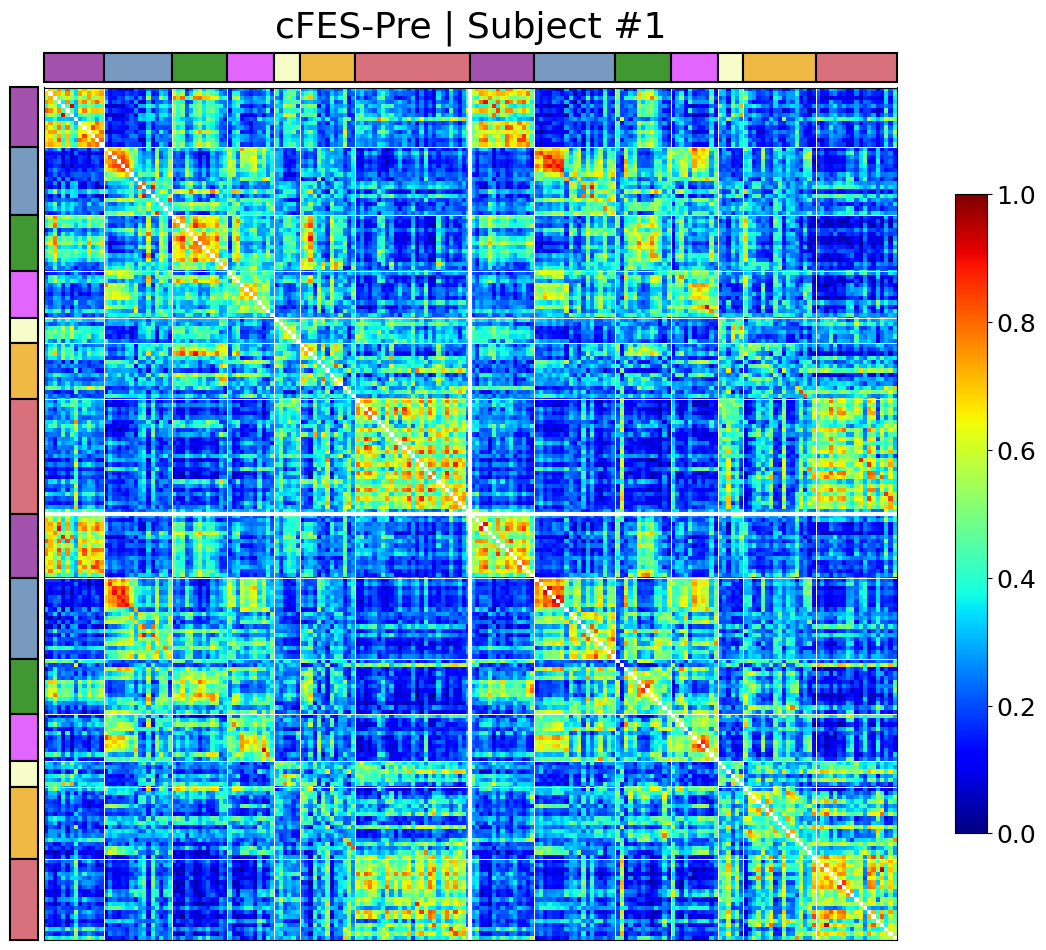

In [114]:
# --- Select a subject set (1..24), then PRINT a single allegiance entry and plot the matrix ---

# Selection (edit these)
s_idx = 0   # 0-based subject set index (0..23)

i, j = 22, 18  # node indices (0-based) whose allegiance value you want to print
# Trying to detect the allegiance value of two brain regions (nodes) by their positions in the matrix between 
# those two nodes—i.e., how consistently they’re assigned to the same community across windows for that subject/set.
# Valid indices are 0…199 for a 200×200 matrix.
# Note: A_sel[i, i] (diagonal) is typically 1, and the matrix is symmetric (A_sel[i, j] == A_sel[j, i]).

# ---- Map set index -> group label (per your ranges) ----
set_num = s_idx + 1  # convert to 1-based for readability
if 1 <= set_num <= 6:
    grp_label, grp_start = 'cFES-Pre', 1
elif 7 <= set_num <= 11:
    grp_label, grp_start = 'Cycling-Pre', 7
elif 12 <= set_num <= 18:
    grp_label, grp_start = 'cFES-Post', 12
elif 19 <= set_num <= 23:  # note: 24 will fall into "(Unlabeled)" per your ranges
    grp_label, grp_start = 'Cycling-Post', 19
else:
    grp_label, grp_start = '(Unlabeled)', set_num
subj_in_group = set_num - grp_start + 1

# Slice allegiance matrix (200x200) for that subject set (no window selection)
A_sel = allegiance[s_idx]  # expected shape: (200, 200)

# Print the requested allegiance entry
print(f"[{grp_label}] Allegiance[set {set_num} | subj {subj_in_group}][{i},{j}] = {A_sel[i, j]:.4f}")

groups=["cFES-Pre", "Passive-Pre", "cFES-Post", "Passive-Post"]

# -------- Plot (keep original structure; swap allegiance[0] -> A_sel) --------
cmap='jet'
f = plt.figure(figsize=(15,11))
plt.matshow(A_sel, fignum=f.number, vmin=0, vmax=1, cmap=cmap)
# plt.title(f"{grp_label} | Subject #7", fontsize=26, y=1.05)  #{set_num}
plt.title(f"{groups[0]} | Subject #1", fontsize=26, y=1.05)
plt.xticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
plt.yticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params(labelsize=18)
plt.axvline(x=100-0.5, color='white', linewidth=3)
plt.axhline(y=100-0.5, color='white', linewidth=3)
plt.grid(color='white', linestyle='-', linewidth=0.7)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labeltop=False, labelleft=False)

xmin, xmax, ymin, ymax = plt.axis()
h = (ymax-ymin)/30; space = h/5; i_marker = ymax + space
plt.gca().add_patch(patches.Rectangle((-0.5, i_marker), width=13.5+0.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((13.5, i_marker), width=29.5-13.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((29.5, i_marker), width=42.5-29.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((42.5, i_marker), width=53.5-42.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((53.5, i_marker), width=59.5-53.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((59.5, i_marker), width=72.5-59.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((72.5, i_marker), width=99.5-72.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((99.5, i_marker), width=114.5-99.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((114.5, i_marker), width=133.5-114.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((133.5, i_marker), width=146.5-133.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((146.5, i_marker), width=157.5-146.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((157.5, i_marker), width=163.5-157.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((163.5, i_marker), width=180.5-163.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((180.5, i_marker), width=199.5-180.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

w = (ymax-ymin)/30; i_marker2 = ymax
plt.gca().add_patch(patches.Rectangle((i_marker2+space, -0.5), width=w, height=13.5+0.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 13.5), width=w, height=29.5-13.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 29.5), width=w, height=42.5-29.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 42.5), width=w, height=53.5-42.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 53.5), width=w, height=59.5-53.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 59.5), width=w, height=72.5-59.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 72.5), width=w, height=99.5-72.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 99.5), width=w, height=114.5-99.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 114.5), width=w, height=133.5-114.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 133.5), width=w, height=146.5-133.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 146.5), width=w, height=157.5-146.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 157.5), width=w, height=163.5-157.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 163.5), width=w, height=180.5-163.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
plt.gca().add_patch(patches.Rectangle((i_marker2+space, 180.5), width=w, height=199.5-180.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

plt.show()


In [115]:
# --- Save 300dpi PNGs for all 24 subjects grouped as 7,5,7,5 ---

# Output directory
out_dir = BASE_DIR / "allegiance_png_300dpi_200_regions"
out_dir.mkdir(parents=True, exist_ok=True)

# Node indices to print (keep your choice)
i, j = 22, 18  # 0-based, valid range 0..199

for s_idx in range(24):  # 0..23
    # ---- Map set index -> group label using 7,5,7,5 partition ----
    set_num = s_idx + 1  # convert to 1-based
    if 1 <= set_num <= 7:
        grp_label, grp_start = 'cFES-Pre', 1
    elif 8 <= set_num <= 12:
        grp_label, grp_start = 'Cycling-Pre', 8
    elif 13 <= set_num <= 19:
        grp_label, grp_start = 'cFES-Post', 13
    elif 20 <= set_num <= 24:
        grp_label, grp_start = 'Cycling-Post', 20
    else:
        grp_label, grp_start = '(Unlabeled)', set_num
    subj_in_group = set_num - grp_start + 1

    # Slice allegiance matrix (200x200) for that subject set (no window selection)
    A_sel = allegiance[s_idx]  # expected shape: (200, 200)

    # Print the requested allegiance entry
    print(f"[{grp_label}] Allegiance[set {set_num} | subj {subj_in_group}][{i},{j}] = {A_sel[i, j]:.4f}")

    # -------- Plot (keep original structure; swap allegiance[0] -> A_sel) --------
    cmap='jet'
    f = plt.figure(figsize=(15,11))
    plt.matshow(A_sel, fignum=f.number, vmin=0, vmax=1, cmap=cmap)
    plt.title(f"{grp_label} | Subject #{subj_in_group}", fontsize=26, y=1.05)
    plt.xticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    plt.yticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    cb = plt.colorbar(shrink=0.75)
    cb.ax.tick_params(labelsize=18)
    plt.axvline(x=100-0.5, color='white', linewidth=3)
    plt.axhline(y=100-0.5, color='white', linewidth=3)
    plt.grid(color='white', linestyle='-', linewidth=0.7)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labeltop=False, labelleft=False)
    
    xmin, xmax, ymin, ymax = plt.axis()
    h = (ymax-ymin)/30; space = h/5; i_marker = ymax + space
    plt.gca().add_patch(patches.Rectangle((-0.5, i_marker), width=13.5+0.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((13.5, i_marker), width=29.5-13.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((29.5, i_marker), width=42.5-29.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((42.5, i_marker), width=53.5-42.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((53.5, i_marker), width=59.5-53.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((59.5, i_marker), width=72.5-59.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((72.5, i_marker), width=99.5-72.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((99.5, i_marker), width=114.5-99.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((114.5, i_marker), width=133.5-114.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((133.5, i_marker), width=146.5-133.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((146.5, i_marker), width=157.5-146.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((157.5, i_marker), width=163.5-157.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((163.5, i_marker), width=180.5-163.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((180.5, i_marker), width=199.5-180.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    
    w = (ymax-ymin)/30; i_marker2 = ymax
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, -0.5), width=w, height=13.5+0.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 13.5), width=w, height=29.5-13.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 29.5), width=w, height=42.5-29.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 42.5), width=w, height=53.5-42.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 53.5), width=w, height=59.5-53.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 59.5), width=w, height=72.5-59.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 72.5), width=w, height=99.5-72.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 99.5), width=w, height=114.5-99.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 114.5), width=w, height=133.5-114.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 133.5), width=w, height=146.5-133.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 146.5), width=w, height=157.5-146.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 157.5), width=w, height=163.5-157.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 163.5), width=w, height=180.5-163.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    plt.gca().add_patch(patches.Rectangle((i_marker2+space, 180.5), width=w, height=199.5-180.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))


    # Save PNG @300dpi
    fname = f"{grp_label.replace(' ', '')}_set{set_num:02d}_subj{subj_in_group:02d}.png"
    plt.savefig(out_dir / fname, dpi=300, bbox_inches='tight')
    plt.close(f)


[cFES-Pre] Allegiance[set 1 | subj 1][22,18] = 0.3600
[cFES-Pre] Allegiance[set 2 | subj 2][22,18] = 0.4000
[cFES-Pre] Allegiance[set 3 | subj 3][22,18] = 0.5200
[cFES-Pre] Allegiance[set 4 | subj 4][22,18] = 0.4400
[cFES-Pre] Allegiance[set 5 | subj 5][22,18] = 0.6000
[cFES-Pre] Allegiance[set 6 | subj 6][22,18] = 0.3600
[cFES-Pre] Allegiance[set 7 | subj 7][22,18] = 0.5200
[Cycling-Pre] Allegiance[set 8 | subj 1][22,18] = 0.6800
[Cycling-Pre] Allegiance[set 9 | subj 2][22,18] = 0.5400
[Cycling-Pre] Allegiance[set 10 | subj 3][22,18] = 0.8200
[Cycling-Pre] Allegiance[set 11 | subj 4][22,18] = 0.4400
[Cycling-Pre] Allegiance[set 12 | subj 5][22,18] = 0.3200
[cFES-Post] Allegiance[set 13 | subj 1][22,18] = 0.5200
[cFES-Post] Allegiance[set 14 | subj 2][22,18] = 0.4400
[cFES-Post] Allegiance[set 15 | subj 3][22,18] = 0.4800
[cFES-Post] Allegiance[set 16 | subj 4][22,18] = 0.3800
[cFES-Post] Allegiance[set 17 | subj 5][22,18] = 0.3800
[cFES-Post] Allegiance[set 18 | subj 6][22,18] = 0.640

In [116]:
import sys
np.set_printoptions(threshold=10)   # only shows first x elements
# np.set_printoptions(threshold=sys.maxsize)

A_sel = allegiance[s_idx]
print(A_sel)

[[ nan 0.6  0.46 ... 0.46 0.24 0.2 ]
 [0.6   nan 0.66 ... 0.48 0.32 0.24]
 [0.46 0.66  nan ... 0.36 0.28 0.24]
 ...
 [0.46 0.48 0.36 ...  nan 0.34 0.2 ]
 [0.24 0.32 0.28 ... 0.34  nan 0.72]
 [0.2  0.24 0.24 ... 0.2  0.72  nan]]


Subj 1 cFES-Pre vs Subj 13 cFES-Post; Node [18,20] = 0.6400 vs 0.5600


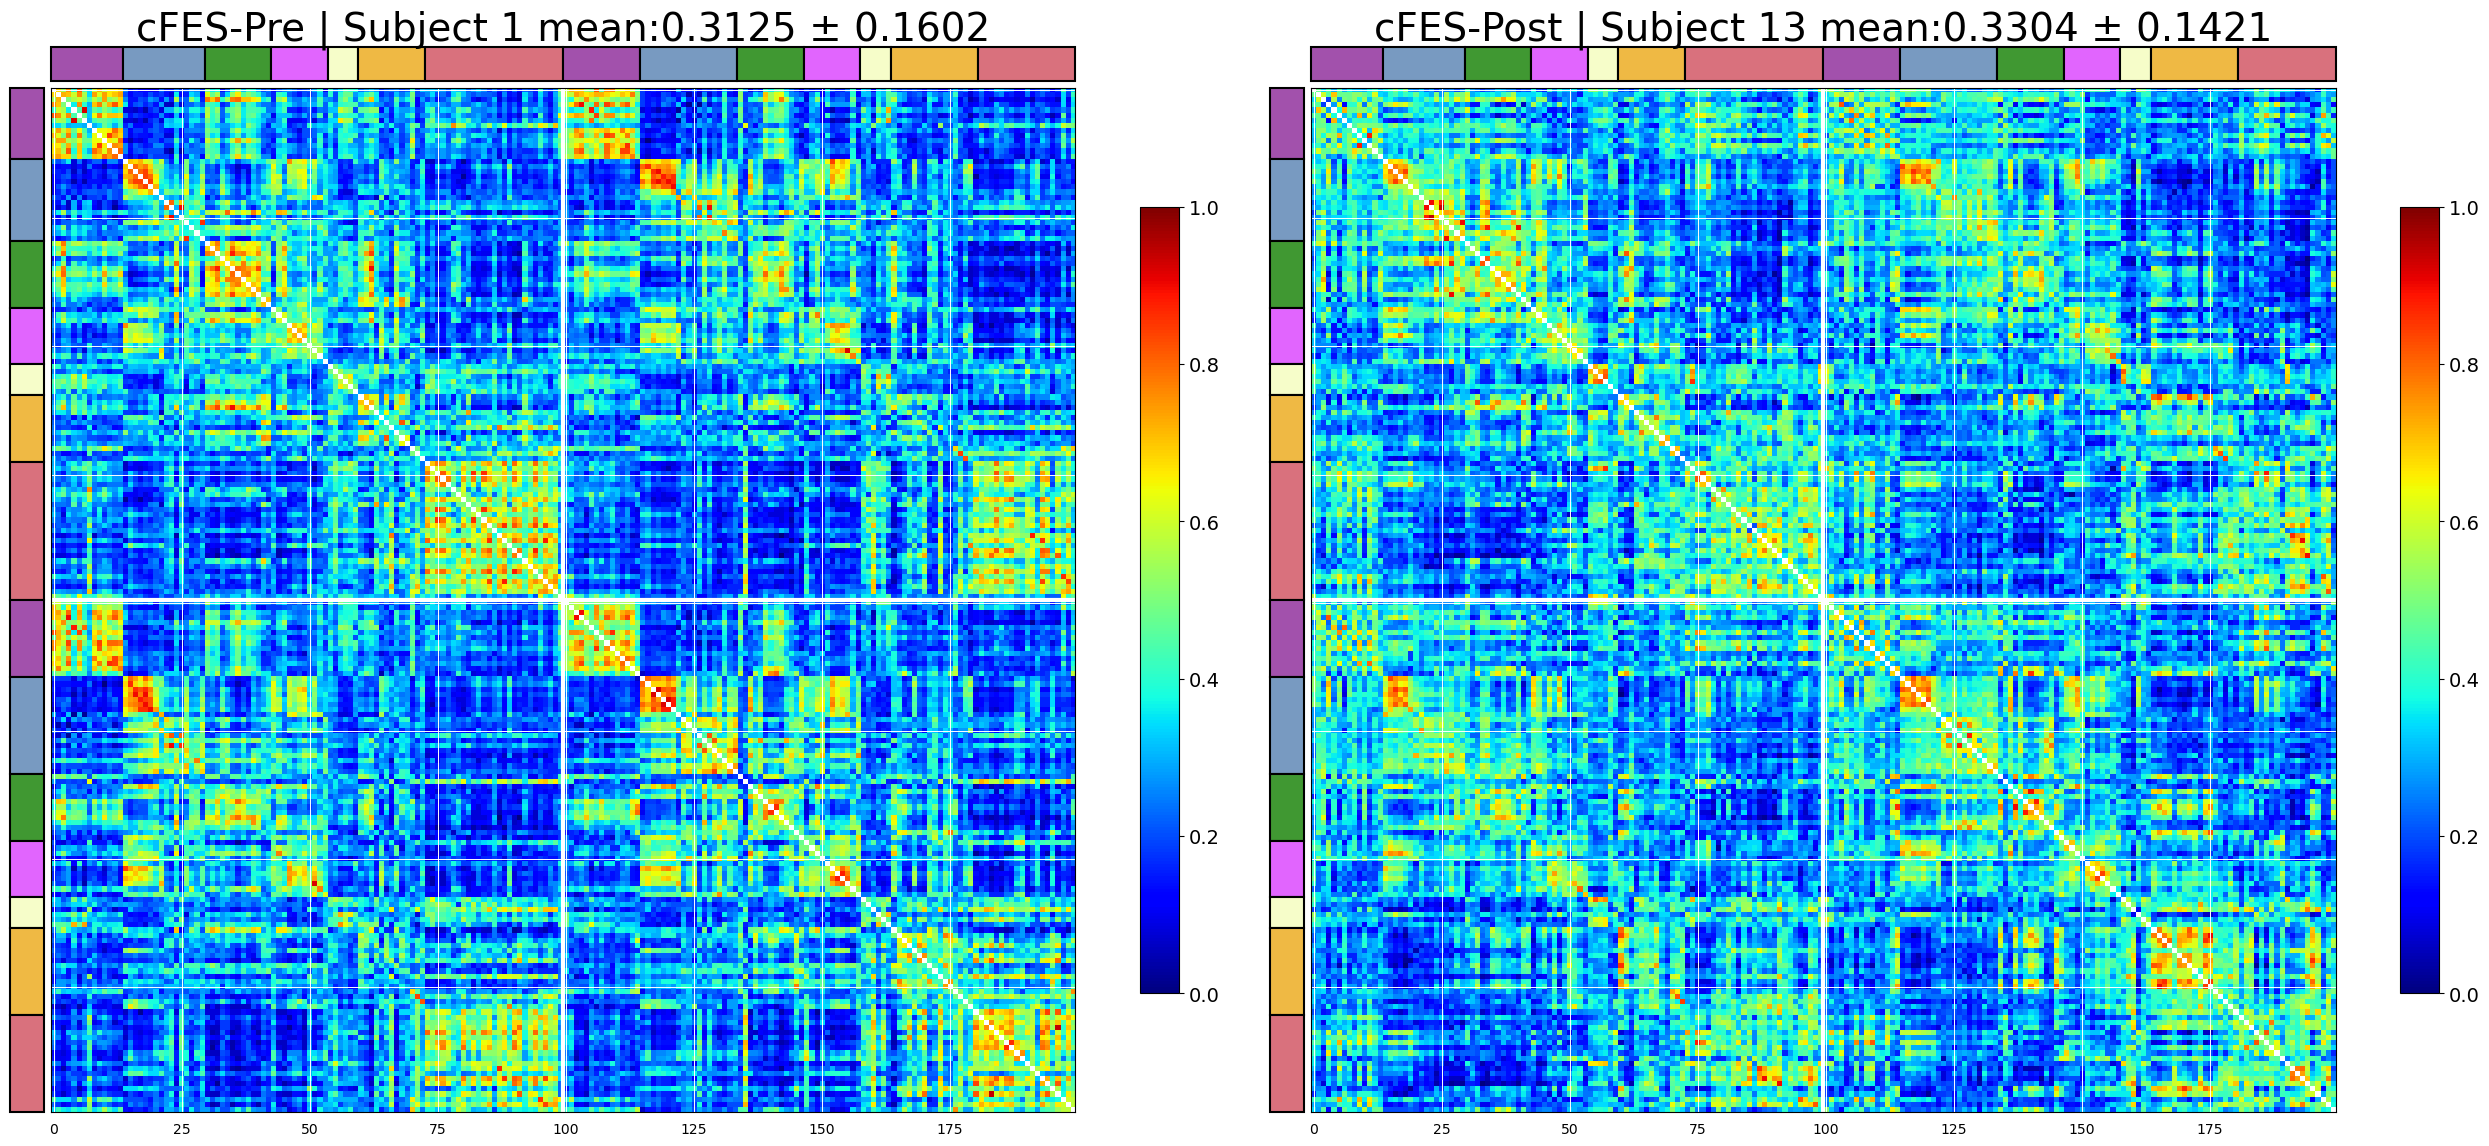

In [117]:
# --- Select two specific subjects (one PreFES, one PostFES) and plot Recruitment vs Integration ---

# 0 - based
s_idx1 = 0   # e.g choose one from 0..3..6 (PreFES) 7..9..11 (PreNFES) 1st, 4th, 7th; 1st, 3rd, 5th
s_idx2 = 12  # e.g choose one from 12..15..18 (PostFES) 19..21..23 (PostNFES)

# 1 - based
# 1–7: cFES-Pre (pre_fes)
# 8–12: Cycling-Pre (pre_nfes)
# 13–19: cFES-Post (post_fes)
# 20–24: Cycling-Post (post_nfes)

i, j = 18, 20  # node indices (0-based) whose allegiance value I want to print

def _set_to_group(s_idx: int):
    set_num = s_idx + 1  # 1-based for readability
    if 1 <= set_num <= 7:
        grp_label, grp_start = 'cFES-Pre', 1
    elif 8 <= set_num <= 12:
        grp_label, grp_start = 'Cycling-Pre', 8
    elif 13 <= set_num <= 19:
        grp_label, grp_start = 'cFES-Post', 13
    elif 20 <= set_num <= 24:
        grp_label, grp_start = 'Cycling-Post', 20
    else:
        grp_label, grp_start = '(Other)', set_num
    subj_in_group = set_num - grp_start + 1
    return grp_label, set_num, subj_in_group

# Slice allegiance matrices (200x200) for both subject sets (no window selection)
A_sel1 = allegiance[s_idx1]
A_sel2 = allegiance[s_idx2]

# Print the requested allegiance entries
grp_label1, set_num1, subj_in_group1 = _set_to_group(s_idx1)
grp_label2, set_num2, subj_in_group2 = _set_to_group(s_idx2)

print(f"Subj {set_num1} {grp_label1} vs Subj {set_num2} {grp_label2}; Node [{i},{j}] = {A_sel1[i, j]:.4f} vs {A_sel2[i, j]:.4f}")
# print(f"[{grp_label2}] Allegiance[Subj {set_num2}] [{i},{j}] = {A_sel2[i, j]:.4f}")

# -------- Plot two matrices in 1 row × 2 columns --------
cmap = 'jet'
fig, axes = plt.subplots(1, 2, figsize=(26, 11))

for ax, A_sel, (grp_label, set_num, subj_in_group) in zip(
    axes,
    [A_sel1, A_sel2],
    [ (grp_label1, set_num1, subj_in_group1), (grp_label2, set_num2, subj_in_group2) ]
):
    im = ax.imshow(A_sel, vmin=0, vmax=1, cmap=cmap)
    A_sel = np.nan_to_num(A_sel, nan=0)
    ax.set_title(f"{grp_label} | Subject {set_num} mean:{np.mean(A_sel):.4f} ± {np.std(A_sel):.4f}", fontsize=28, pad=35)
    #ax.set_title(f'cFES-pre\nmean:{np.mean(alg_a):.4f} ± {np.std(alg_a):.4f}', fontsize=26, y=1.04)
    #ax.set_xticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    #ax.set_yticks([13.5, 29.5, 42.5, 53.5, 59.5, 72.5, 99.5, 114.5, 133.5, 146.5, 157.5, 163.5, 180.5])
    cb = fig.colorbar(im, ax=ax, shrink=0.75)
    cb.ax.tick_params(labelsize=14)
    ax.axvline(x=100-0.5, color='white', linewidth=3)
    ax.axhline(y=100-0.5, color='white', linewidth=3)
    ax.grid(color='white', linestyle='-', linewidth=0.7)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    h = (ymax - ymin) / 30.0
    space = h / 5.0
    i_marker = ymax + space

    # Top color bars for networks (X axis)
    ax.add_patch(patches.Rectangle((-0.5, i_marker), width=13.5+0.5,  height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((13.5, i_marker), width=29.5-13.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((29.5, i_marker), width=42.5-29.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((42.5, i_marker), width=53.5-42.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((53.5, i_marker), width=59.5-53.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((59.5, i_marker), width=72.5-59.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((72.5, i_marker), width=99.5-72.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((99.5, i_marker), width=114.5-99.5, height=h, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((114.5, i_marker), width=133.5-114.5, height=h, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((133.5, i_marker), width=146.5-133.5, height=h, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((146.5, i_marker), width=157.5-146.5, height=h, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((157.5, i_marker), width=163.5-157.5, height=h, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((163.5, i_marker), width=180.5-163.5, height=h, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((180.5, i_marker), width=199.5-180.5, height=h, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

    # Right-side color bars for networks (Y axis)
    w = (ymax - ymin) / 30.0
    i_marker2 = ymax
    ax.add_patch(patches.Rectangle((i_marker2 + space, -0.5),  width=w, height=13.5+0.5,  facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 13.5),  width=w, height=29.5-13.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 29.5),  width=w, height=42.5-29.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 42.5),  width=w, height=53.5-42.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 53.5),  width=w, height=59.5-53.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 59.5),  width=w, height=72.5-59.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 72.5),  width=w, height=99.5-72.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 99.5),  width=w, height=114.5-99.5, facecolor='#A251AC', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 114.5), width=w, height=133.5-114.5, facecolor='#789AC1', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 133.5), width=w, height=146.5-133.5, facecolor='#409832', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 146.5), width=w, height=157.5-146.5, facecolor='#E165FE', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 157.5), width=w, height=163.5-157.5, facecolor='#F6FDC9', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 163.5), width=w, height=180.5-163.5, facecolor='#EFB944', clip_on=False, linewidth=1.5, edgecolor='k'))
    ax.add_patch(patches.Rectangle((i_marker2 + space, 180.5), width=w, height=199.5-180.5, facecolor='#D9717D', clip_on=False, linewidth=1.5, edgecolor='k'))

plt.tight_layout()
plt.show()


In [118]:
# x_alg_SMN_c, z_alg_SMN_c = extract_smn_block(A_sel1, A_sel2)
x_alg_SMN_c = extract_smn_block(A_sel1)   # default idx -> (35, 35)
z_alg_SMN_c = extract_smn_block(A_sel2)   # default idx -> (35, 35)
alg_smn_a = x_alg_SMN_c
alg_smn_b = z_alg_SMN_c

alg_smn_a = np.nan_to_num(alg_smn_a, nan=0)
alg_smn_b = np.nan_to_num(alg_smn_b, nan=0)

SMN block shape: (35, 35)
SMN block shape: (35, 35)


NameError: name 'alg_smn_a' is not defined

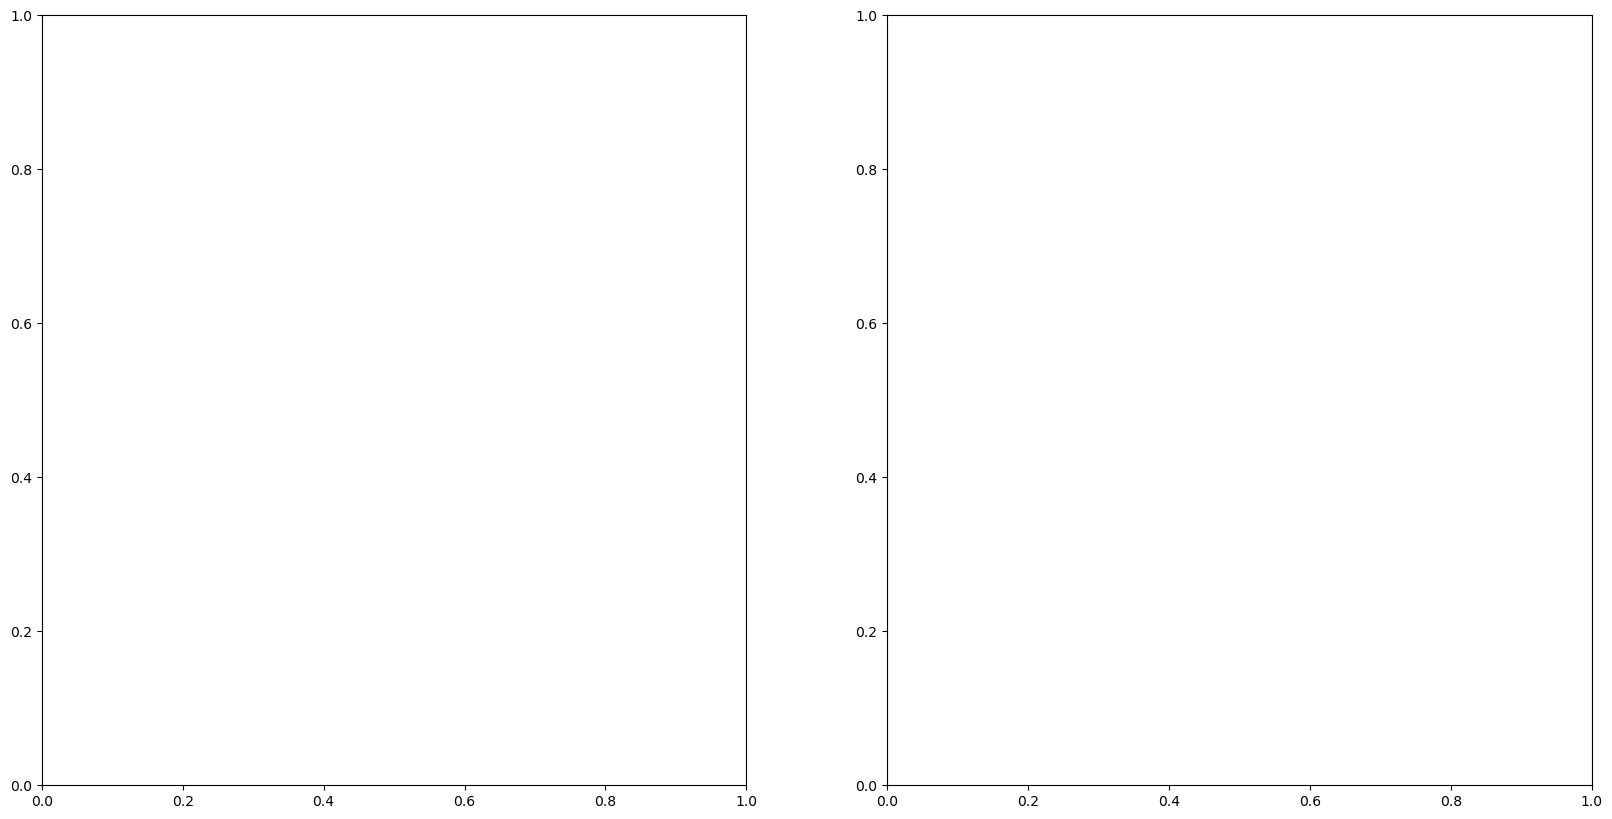

In [22]:
cmap = 'jet'
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot matrices
im1 = axs[0].matshow(alg_smn_a, vmin=0, vmax=1, cmap=cmap)
# axs[0].set_title(f'{grp_label1} (SMN) - Subject #1', fontsize=26, y=1.08)

im2 = axs[1].matshow(alg_smn_b, vmin=0, vmax=1, cmap=cmap)
# axs[1].set_title(f'{grp_label2} (SMN) - Subject #1', fontsize=26, y=1.08)

for ax in axs:
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)
    ax.grid(color='white', linestyle='-', linewidth=0.7)

    # 4 region groups
    group_sizes  = [7, 9, 7, 12]               # widths/heights in matrix index space
    # group_colors = ['cyan', 'lime', 'cyan', 'lime']
    group_colors = ['lime', 'cyan', 'lime', 'cyan']

    xmin, xmax, ymin, ymax = ax.axis()
    h = (ymax - ymin) / 30.0
    space = h / 5.0

    # positions for normal group bars
    top_y_groups   = ymax + space               # cyan/lime top bar (original)
    right_x_groups = xmax + space+0.5             # cyan/lime right bar (original)

    # bar thickness for right side (same style as before)
    w = (xmax - xmin) / 30.0

    # NOW push the blue bar OUTSIDE the cyan/lime bar
    top_y_outer   = top_y_groups + h + space    # blue on top
    right_x_outer = right_x_groups + w + space +1.65  # blue on the right (← this was the issue)

    # totals
    total_width  = sum(group_sizes)
    total_height = sum(group_sizes)

    # we want:
    # blue part 1  = (group 1 + group 2)
    # blue part 2  = (group 3 + group 4)
    top_blue_1 = group_sizes[0] + group_sizes[1]
    top_blue_2 = group_sizes[2] + group_sizes[3]

    right_blue_1 = group_sizes[0] + group_sizes[1]
    right_blue_2 = group_sizes[2] + group_sizes[3]

    # ==================================================
    # OUTERMOST TOP BAR (2 pieces, aligned with 1st+2nd, 3rd+4th groups)
    # ==================================================
    # first blue (over groups 1+2)
    ax.add_patch(
        patches.Rectangle(
            (-0.5, top_y_outer),
            top_blue_1,
            h,
            facecolor='#789AC1', ##789AC1 blue
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )
    # second blue (over groups 3+4)
    ax.add_patch(
        patches.Rectangle(
            (-0.5 + top_blue_1, top_y_outer),
            top_blue_2,
            h,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )

    # ==================================================
    # OUTERMOST RIGHT BAR (2 pieces, aligned with 1st+2nd, 3rd+4th groups)
    # ==================================================
    # first blue (beside groups 1+2)
    ax.add_patch(
        patches.Rectangle(
            (right_x_outer, -0.5),
            h,
            right_blue_1,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )
    # second blue (beside groups 3+4)
    ax.add_patch(
        patches.Rectangle(
            (right_x_outer, -0.5 + right_blue_1),
            h,
            right_blue_2,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )

    # ==================================================
    # EXISTING group-level bars (cyan/lime) — stay closer to the matrix
    # ==================================================
    # TOP bars
    start_x = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(
            patches.Rectangle(
                (start_x, top_y_groups), size, h,
                facecolor=color, edgecolor='k',
                linewidth=1.2, clip_on=False
            )
        )
        start_x += size

    # RIGHT bars
    start_y = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(
            patches.Rectangle(
                (right_x_groups, start_y), w, size,
                facecolor=color, edgecolor='k',
                linewidth=1.2, clip_on=False
            )
        )
        start_y += size

    # draw grid boundaries
    boundaries = np.cumsum(group_sizes)[:-1] - 0.5
    for b in boundaries:
        ax.axvline(b, color='white', linewidth=2)
        ax.axhline(b, color='white', linewidth=2)

# Single colorbar
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', fraction=0.02, shrink=0.85)
cbar.ax.tick_params(labelsize=26)

plt.show()


In [131]:
# --- Save SMN-only (35x35) allegiance figures for all 24 subjects, one image per figure ---

out_dir = BASE_DIR / "allegiance_png_300dpi_SMN"
out_dir.mkdir(parents=True, exist_ok=True)

for s_idx in range(24):  # 0..23
    # ---- Map set index -> group label using 7,5,7,5 partition ----
    set_num = s_idx + 1  # convert to 1-based
    if 1 <= set_num <= 7:
        grp_label, grp_start = 'cFES-Pre', 1
    elif 8 <= set_num <= 12:
        grp_label, grp_start = 'Cycling-Pre', 8
    elif 13 <= set_num <= 19:
        grp_label, grp_start = 'cFES-Post', 13
    elif 20 <= set_num <= 24:
        grp_label, grp_start = 'Cycling-Post', 20
    else:
        grp_label, grp_start = '(Unlabeled)', set_num
    subj_in_group = set_num - grp_start + 1

    # Extract 35x35 SMN block for this subject
    A_full = allegiance[s_idx]            # (200, 200)
    alg_smn = extract_smn_block(A_full)   # default idx -> (35, 35)

    # ---- Plot a single SMN matrix figure ----
    cmap = 'jet'
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.matshow(alg_smn, vmin=0, vmax=1, cmap=cmap)
    # ax.set_title(f'{grp_label} | Subject #{subj_in_group}',
                 # fontsize=22, y=1.08)

    # Styling to match your original look
    ax.tick_params(axis='both', which='both',
                   bottom=False, top=False, left=False, right=False,
                   labeltop=False, labelleft=False)
    ax.grid(color='white', linestyle='-', linewidth=0.7)

    # ---- Divide into 4 region groups: 6, 10, 6, 13 ----
    group_sizes  = [7, 9, 7, 12]
    # group_colors = ['cyan', 'lime', 'cyan', 'lime']
    group_colors = ['lime', 'cyan', 'lime', 'cyan']

    xmin, xmax, ymin, ymax = ax.axis()
    h = (ymax - ymin) / 30.0
    space = h / 5.0

    # positions for normal group bars
    top_y_groups   = ymax + space               # cyan/lime top bar (original)
    right_x_groups = xmax + space+0.5             # cyan/lime right bar (original)

    # bar thickness for right side (same style as before)
    w = (xmax - xmin) / 30.0

    # ==================================================
    # OUTERMOST BLUE BARS (top & right), in 2 chunks (1+2) and (3+4)
    # ==================================================
    top_y_outer   = top_y_groups + h + space           # blue above cyan/lime
    right_x_outer = right_x_groups + w + space + 1.65  # blue to the right of cyan/lime

    # blue spans
    top_blue_1   = group_sizes[0] + group_sizes[1]     # groups 1+2
    top_blue_2   = group_sizes[2] + group_sizes[3]     # groups 3+4
    right_blue_1 = group_sizes[0] + group_sizes[1]
    right_blue_2 = group_sizes[2] + group_sizes[3]

    # --- TOP blue bar: part 1 (over groups 1+2)
    ax.add_patch(
        patches.Rectangle(
            (-0.5, top_y_outer),
            top_blue_1,
            h,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )
    # --- TOP blue bar: part 2 (over groups 3+4)
    ax.add_patch(
        patches.Rectangle(
            (-0.5 + top_blue_1, top_y_outer),
            top_blue_2,
            h,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )

    # --- RIGHT blue bar: part 1 (beside groups 1+2)
    ax.add_patch(
        patches.Rectangle(
            (right_x_outer, -0.5),
            h,
            right_blue_1,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )
    # --- RIGHT blue bar: part 2 (beside groups 3+4)
    ax.add_patch(
        patches.Rectangle(
            (right_x_outer, -0.5 + right_blue_1),
            h,
            right_blue_2,
            facecolor='#789AC1',
            edgecolor='k',
            linewidth=1.5,
            clip_on=False
        )
    )

    # ==================================================
    # EXISTING group-level bars (cyan/lime) — stay closer to the matrix
    # ==================================================
    # Top bars (horizontal group indicators)
    start_x = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(patches.Rectangle((start_x, top_y_groups), size, h,
                                       facecolor=color, edgecolor='k',
                                       linewidth=1.2, clip_on=False))
        start_x += size

    # Right bars (vertical group indicators)
    start_y = -0.5
    for size, color in zip(group_sizes, group_colors):
        ax.add_patch(patches.Rectangle((right_x_groups, start_y), w, size,
                                       facecolor=color, edgecolor='k',
                                       linewidth=1.2, clip_on=False))
        start_y += size

    # Draw separating lines at boundaries between groups
    boundaries = np.cumsum(group_sizes)[:-1] - 0.5
    for b in boundaries:
        ax.axvline(b, color='white', linewidth=2)
        ax.axhline(b, color='white', linewidth=2)

    # Single colorbar per figure
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.09)
    cbar.ax.tick_params(labelsize=28)

    # ---- Save one image per figure (300 dpi) ----
    fname = f"{grp_label.replace(' ', '')}_SMN_set{set_num:02d}_subj{subj_in_group:02d}.png"
    fig.savefig(out_dir / fname, dpi=300, bbox_inches='tight')
    plt.close(fig)


SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)
SMN block shape: (35, 35)


In [31]:
# # === Build in-memory SMN variables for 24 subjects (no XLSX) ===

# # --- SMN index ranges (must match your extract_* defaults) ---
# _SMN_IDX1 = (14, 30)   # 16 ROIs
# _SMN_IDX2 = (115, 134) # 19 ROIs
# _SMN_LEN  = (_SMN_IDX1[1] - _SMN_IDX1[0]) + (_SMN_IDX2[1] - _SMN_IDX2[0])  # 35

# # Sanity checks
# assert len(recruitment) == n_set == 24, "Recruitment list length must be 24."
# assert len(integration) == 24 and len(allegiance) == 24, "Integration/Allegiance lists must be 24."
# for s in range(24):
#     R, I, A = recruitment[s], integration[s], allegiance[s]
#     assert R.shape == (200,), f"recruitment[{s}] must be (200,), got {R.shape}"
#     assert I.shape == (200,), f"integration[{s}] must be (200,), got {I.shape}"
#     assert A.shape == (200, 200), f"allegiance[{s}] must be (200,200), got {A.shape}"

# # Preallocate in-memory arrays
# RC_smn_all  = np.zeros((24, _SMN_LEN), dtype=float)      # (24, 35)
# IC_smn_all  = np.zeros((24, _SMN_LEN), dtype=float)      # (24, 35)
# ALG_smn_all = np.zeros((24, _SMN_LEN, _SMN_LEN), float)  # (24, 35, 35)

# for s in range(24):
#     # Original full vectors/matrix
#     R = np.asarray(recruitment[s]).reshape(-1)
#     I = np.asarray(integration[s]).reshape(-1)
#     A = np.asarray(allegiance[s])

#     # --- Apply SMN extraction ---
#     R_smn = extract_SMN_slices(R, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)   # (35,)
#     I_smn = extract_SMN_slices(I, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)   # (35,)
#     A_smn = extract_smn_block(A, idx1=_SMN_IDX1, idx2=_SMN_IDX2, verbose=False)    # (35,35)

#     RC_smn_all[s, :]      = R_smn
#     IC_smn_all[s, :]      = I_smn
#     ALG_smn_all[s, :, :]  = A_smn

# print("In-memory SMN arrays created:")
# print("  RC_smn_all :", RC_smn_all.shape)
# print("  IC_smn_all :", IC_smn_all.shape)
# print("  ALG_smn_all:", ALG_smn_all.shape)

# # -----------------------------------------------------------
# # LEMS data (as provided) — map to 24 subjects in 4 blocks
# # Order we will use (to match 7,5,7,5 subject partition):
# # 1–7   : cFES-Pre
# # 8–12  : Passive-Pre
# # 13–19 : cFES-Post
# # 20–24 : Passive-Post
# # -----------------------------------------------------------

# # Provided values
# lems_cfes_pre   = np.array([5, 8, 19, 43, 0, 6, 5], dtype=float)   # 7
# lems_cfes_post  = np.array([8, 11, 17, 45, 0, 14, 6], dtype=float) # 7
# lems_pass_pre   = np.array([0, 39, 4, 9, 0], dtype=float)          # 5
# lems_pass_post  = np.array([0, 37, 6, 11, 3], dtype=float)         # 5

# # Build 24-length arrays in the order above
# LEMS_pre_all  = np.zeros(24, dtype=float)
# LEMS_post_all = np.zeros(24, dtype=float)


## Statistical Analysis

### 15. Prepare data for Analysis

### 16. Compute delta RC, IC, LEMS 

### 17. Permutation Analysis Setup

In [48]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 4:19:53.206852
